<a href="https://colab.research.google.com/github/mounika1983/IK-Assignments/blob/main/ML_miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mounika Kakanuru**
mounikapg@gmail.com

## **Understanding Networks through Clustering**

# **1. Add the required pyhton library imports**

In [ ]:
pip install -U node2vec

In [ ]:
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import random
import itertools

from itertools import combinations, groupby
from node2vec import Node2Vec
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from networkx.algorithms import approximation
from networkx.algorithms import reciprocity
from collections import Counter
from community import community_louvain
from networkx.algorithms import community

%matplotlib inline

# **2. Understanding Real-life dataset**
## It contains the following info:

This dataset consists of 'circles' (or 'friends lists') from Facebook. Facebook data was collected from survey participants using this Facebook app. The dataset includes node features (profiles), circles, and ego networks.

Facebook data has been anonymized by replacing the Facebook-internal ids for each user with a new value. Also, while feature vectors from this dataset have been provided, the interpretation of those features has been obscured. For instance, where the original dataset may have contained a feature "political=Democratic Party", the new data would simply contain "political=anonymized feature 1". Thus, using the anonymized data it is possible to determine whether two users have the same political affiliations, but not what their individual political affiliations represent.

**NOTE:** Data is also available from Google+ and Twitter.



## Load the Data in Memory

*   Read Data from Google Drive
*   Prepares the graph with nodes and edges by reading the file.

In [ ]:
# for google colab, we need to mount the drive where the data is stored
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# file path for the training data
facebook_data = "/content/drive/MyDrive/ML-MiniProject/facebook/dataset/facebook_combined.txt"
circles_107 = "/content/drive/MyDrive/ML-MiniProject/facebook/107.circles"
edges_107 = "/content/drive/MyDrive/ML-MiniProject/facebook/107.edges"
edges_0 = "/content/drive/MyDrive/ML-MiniProject/facebook/0.edges"
circles_0 = "/content/drive/MyDrive/ML-MiniProject/facebook/0.circles"

In [ ]:
G_combined = nx.read_edgelist(facebook_data, create_using = nx.Graph(), nodetype=int)
G_107 = nx.read_edgelist(edges_107, nodetype=int)
G_0 = nx.read_edgelist(edges_0, nodetype=int)

# **3. Network Summaries**
## Input:

*   `edgelist:` an edge list for the network
*   `vertices:` labels of vertices in the network (must correspond with the entries in edgelist)
*   `subgraph:` a list of vertex labels from vertices you would like to visualize. Set the default to be vertices.
*   `directed:` a logical indicating whether or not the network is directed

## Output:

### 1. Visualizations
*   The induced subgraph that has vertex set subgraph and edge set equal to all the edge weights between the vertices in subgraph.
*   The degree distribution of subgraph. In the case that directed = TRUE, provide plots of both the in- and out- degree distributions.
*   The betweenness centrality distribution of the subgraph vertices (where betweenness is calculated on the induced subgraph not on the entire graph)
*   The eigenvector centrality distribution of the subgraph vertices (where eigenvector cen- tralities are calculated on the induced subgraph not on the entire graph)

### 2. Local Summaries:
*   For each vertex in subgraph, store its eigenvector centrality, betweenness centrality, the degree, and closeness centrality

### 3. Global Summaries:
*   Store the diameter, clustering coefficient, number of nodes, number of edges for the network, number of connected components, size of the largest connected component of the induced subgraph from the subgraph vertices.


In [ ]:
def explore_and_summarize_network(edgelist, vertices, subgraph, directed=False):
    """
    Concisely summarizes any induced subgraph of the input network
    """
    G = nx.Graph()
    if subgraph is not None:
        induced_edges = [ edge for edge in edgelist if ((edge[0] in subgraph) and (edge[1] in subgraph))]
        G.add_nodes_from(subgraph)
        G.add_edges_from(induced_edges, nodetype=int)
    else :
        G.add_nodes_from(vertices)
        G.add_edges_from(edgelist, nodetype=int)

    # (a)
    nx.draw(G,pos=nx.spring_layout(G),node_color='maroon',
        node_size=20,
        edge_color="gray",
        width=0.5)
    plt.show()

    # (b)
    if directed:
        in_degrees = [G.in_degree(n) for n in G.nodes]
        in_degree_counts = Counter(in_degrees)
        fig, ax = plt.subplots()
        ax.bar(in_degree_counts.keys(), in_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('In Degrees')
        ax.set_title(r'Histogram of in_degrees')
        fig.tight_layout()
        plt.show()

        out_degrees = [G.in_degree(n) for n in G.nodes]
        out_degree_counts = Counter(out_degrees)
        fig, ax = plt.subplots()
        ax.bar(out_degree_counts.keys(), out_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of out_degrees')
        fig.tight_layout()
        plt.show()
    else:
        degrees = [G.degree(n) for n in G.nodes]
        degree_counts = Counter(degrees)
        fig, ax = plt.subplots()
        ax.bar(degree_counts.keys(), degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('Degrees')
        ax.set_title(r'Histogram of degrees')
        fig.tight_layout()
        plt.show()

    # (c)
    betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
    fig1, ax1 = plt.subplots()
    ax1.hist(list(betweenness_centrality.values()))
    ax1.set_xlabel('Nodes')
    ax1.set_ylabel('Betweenness Centrality')
    ax1.set_title(r'Histogram of Betweenness Centrality')
    fig1.tight_layout()
    plt.show()

    # (d)
    eigenvector_centrality = nx.eigenvector_centrality(G)
    fig2, ax2 = plt.subplots()
    ax2.hist(list(eigenvector_centrality.values()))
    ax2.set_xlabel('Nodes')
    ax2.set_ylabel('Eigenvector Centrality')
    ax2.set_title(r'Histogram of Eigenvector Centrality')
    fig2.tight_layout()
    plt.show()

    # (e)
    closeness_centrality = nx.closeness_centrality(G)
    fig3, ax3 = plt.subplots()
    ax3.hist(list(closeness_centrality.values()))
    ax3.set_xlabel('Nodes')
    ax3.set_ylabel('Closeness Centrality')
    ax3.set_title(r'Histogram of Closeness Centrality')
    fig3.tight_layout()
    plt.show()

    # Print Global Summaries
    global_summaries(G)

## Global Summaries

In [ ]:
def global_summaries(G):
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
    except:
        diameter = "Found infinite path length because the graph is not connected !"
    clustering_coefficient = nx.algorithms.approximation.clustering_coefficient.average_clustering(G)
    number_of_nodes = G.number_of_edges()
    number_of_edges = G.number_of_nodes()
    number_of_connected_components = nx.number_connected_components(G)
    largest_connected_component = max([ len(i) for i in list(nx.connected_components(G))])
    print("\nGlobal Summaries")
    print("Diameter : ",diameter)
    print("Number of Nodes : ",number_of_nodes)
    print("Number of Edges : ",number_of_edges)
    print("Number of Connected Components : ",number_of_connected_components)
    print("Size of the Largest Connected Compopnent : ",largest_connected_component)

## Generate a random undirected graph

In [ ]:
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

## Validating generated random graph

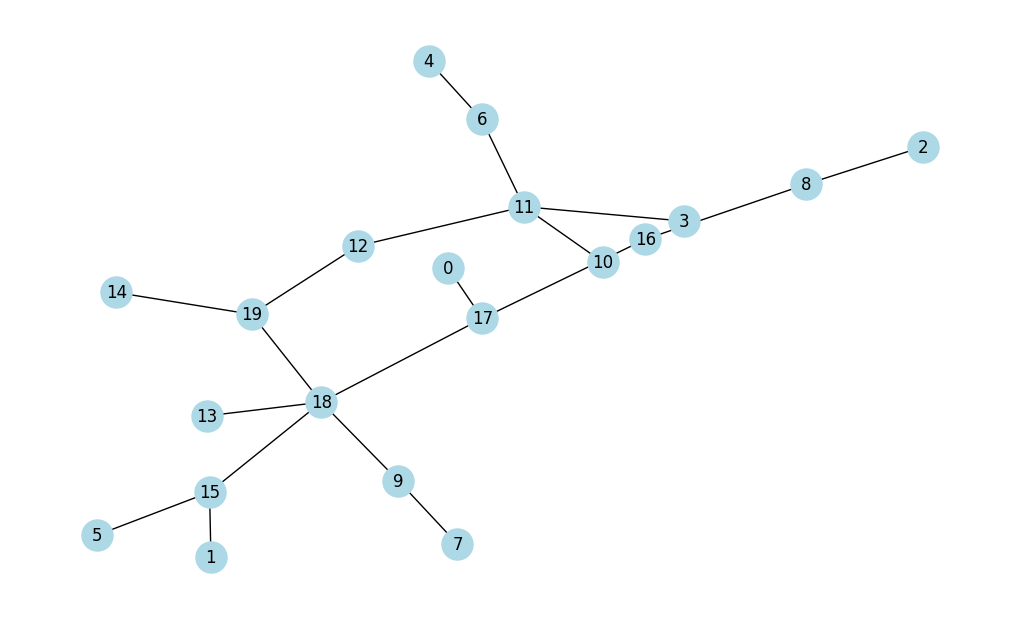

In [ ]:
nodes = 20
seed = random.randint(1,10)
probability = 0.001
G_random = gnp_random_connected_graph(nodes,probability)

plt.figure(figsize=(10,6))

nx.draw(G_random, node_color='lightblue',
        with_labels=True,
        node_size=500)

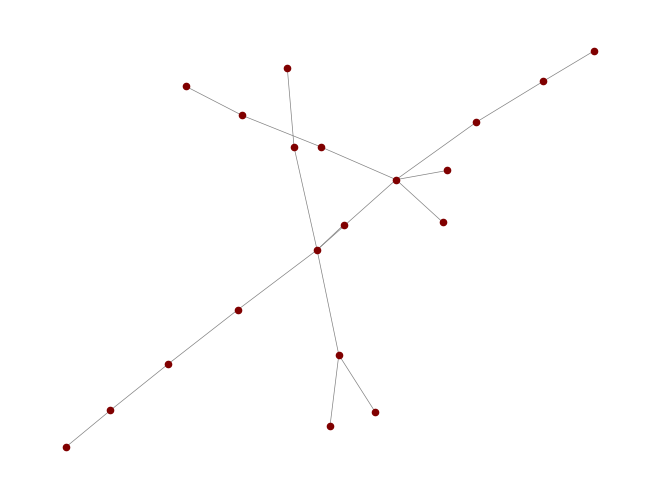

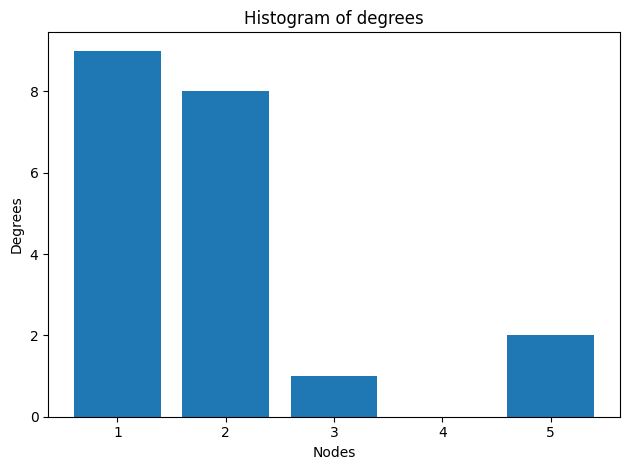

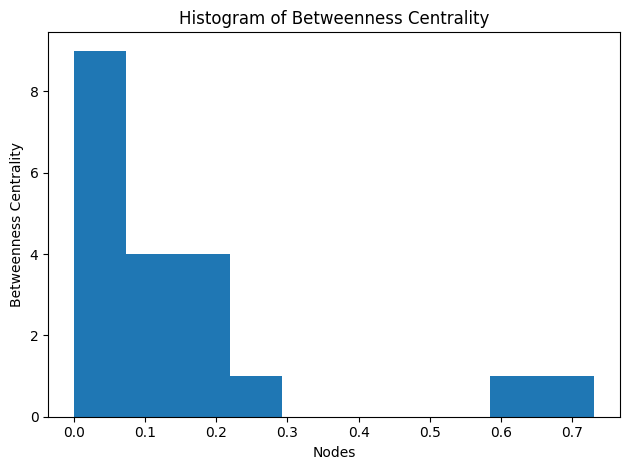

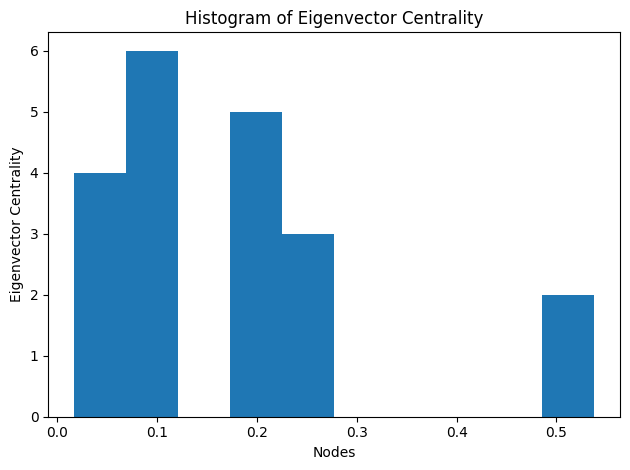

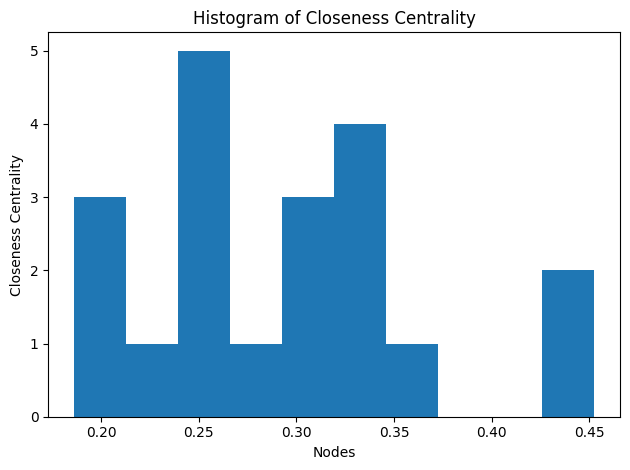


Global Summaries
Diameter :  8
Number of Nodes :  19
Number of Edges :  20
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  20


In [ ]:
explore_and_summarize_network(edgelist = G_random.edges(), vertices=G_random.nodes(), subgraph=None)

## Validating the function with a subgraph

In [ ]:
vertices = list(G_random.nodes())
to_remove = random.sample(range(0, 20), 5)
subgraph_vertices = [e for e in vertices if e not in to_remove]
print("Total removed nodes : ",len(vertices)-len(subgraph_vertices))

Total removed nodes :  5


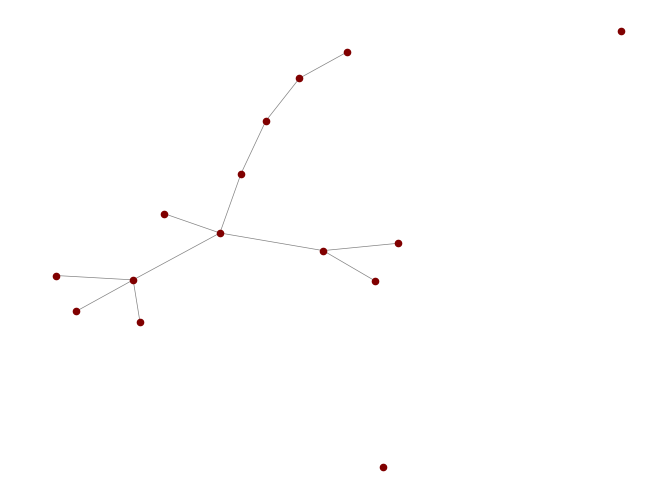

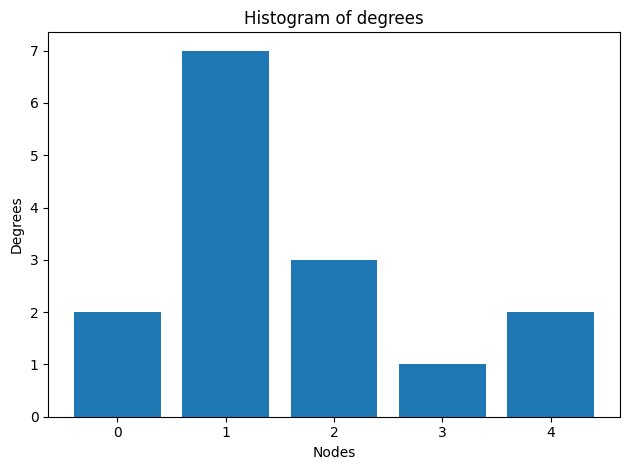

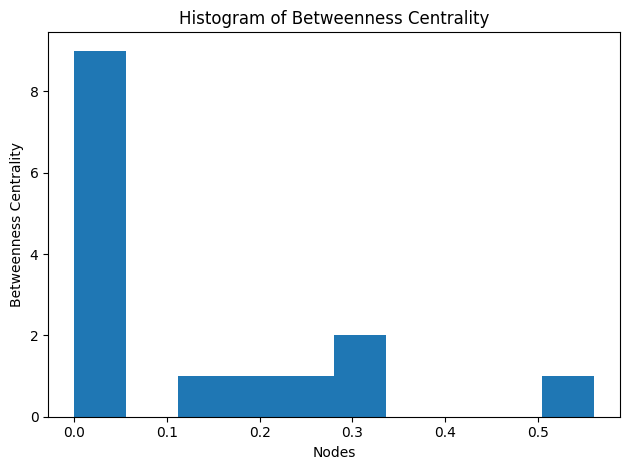

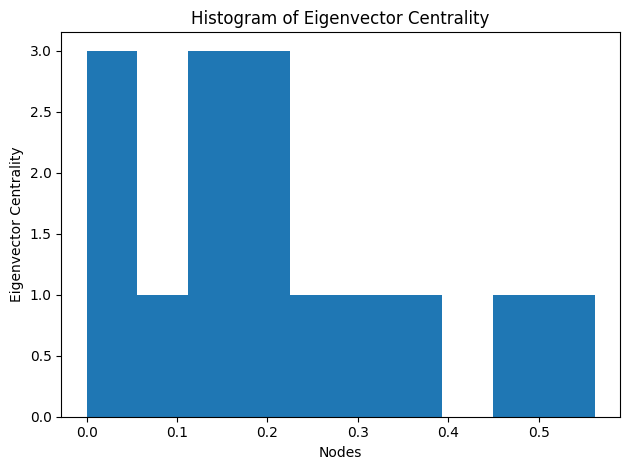

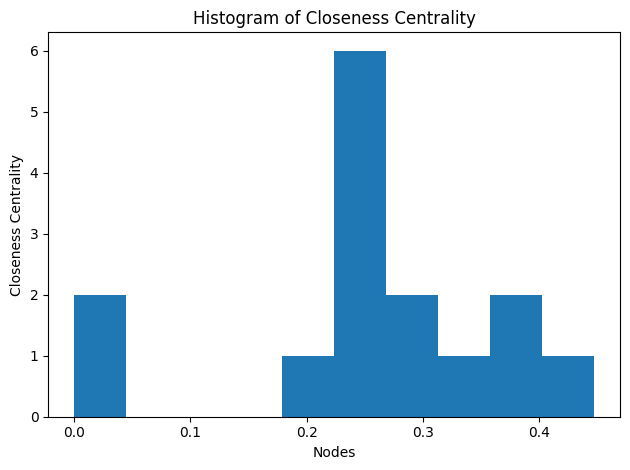


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  12
Number of Edges :  15
Number of Connected Components :  3
Size of the Largest Connected Compopnent :  13


In [ ]:
explore_and_summarize_network(edgelist = G_random.edges(), vertices=G_random.nodes(),
                              subgraph=subgraph_vertices)

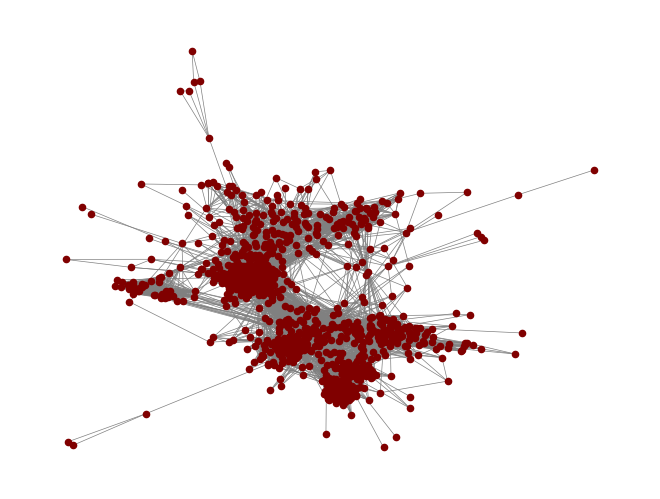

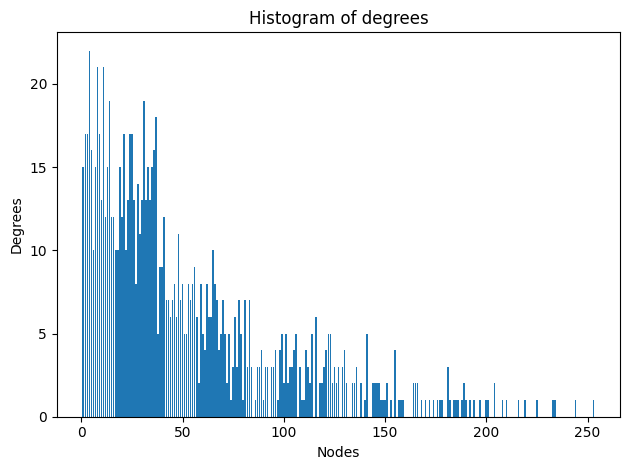

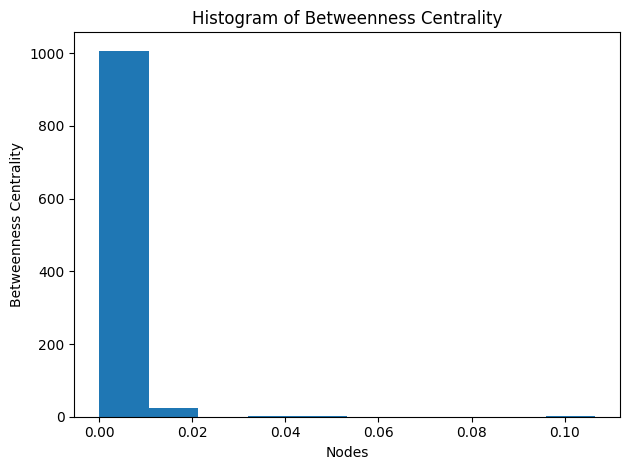

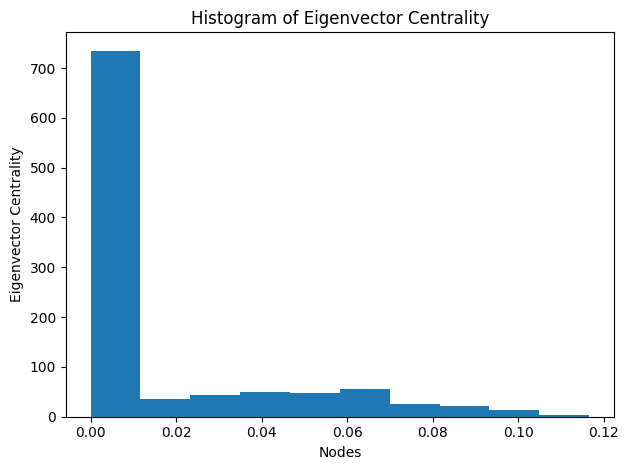

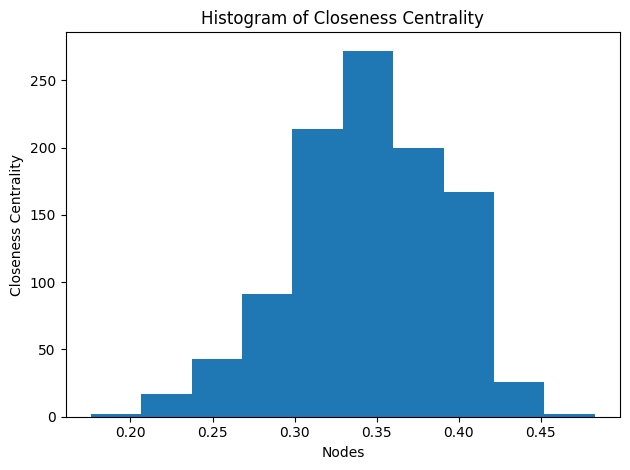


Global Summaries
Diameter :  9
Number of Nodes :  26749
Number of Edges :  1034
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  1034


In [ ]:
explore_and_summarize_network(edgelist = G_107.edges(), vertices=G_107.nodes(), subgraph=None)

# **4. Social Circle Analysis**

People often categorize their friends in terms of social circles. At Facebook, it is of interest to discover an individual’s social circles in a completely data- driven fashion. In this [document](http://i.stanford.edu/~julian/pdfs/nips2012.pdf), they considered this problem and used individuals’ ego-network – the network of their friend’s friendships on Facebook.

For this part, we will look at the social circles for an individual considered in a large Facebook dataset in the document mentioned above. Our goal is to investigate the similarities and differences between the social circles of an individual in the study. First, the data facebook.tar.gz at https://snap.stanford.edu/data/ego-Facebook.html is downloaded. Then below graphs are visualized:

#### 1. The ego-networks visualization for vertex 107 using the function created.

#### 2. Degrees of separation: “6 degrees of separation” experiment at Facebook, which in 2016 showed that on average two people are 3.57 friends apart. Let’s repeat this experiment on the Facebook data we have from above. Full data set of facebook combined.txt.gz used and run the following experiment:

*   choose 2 nodes at random in the network
*   calculate the shortest path between them and store this value
*   repeat (a) and (b) 1000 times

The distribution of the 1000 shortest path lengths plotted.

In [ ]:
def read_circles(file_path):
    with open(file_path) as f :
        content = f.readlines()
        content = [line.replace("\n","") for line in content]
        content = [line.split("\t") for line in content]
    return {circle[0]:list(map(int,circle[1:])) for circle in content} # Convert nodes to int and add to dict.


 CIRCLE0 



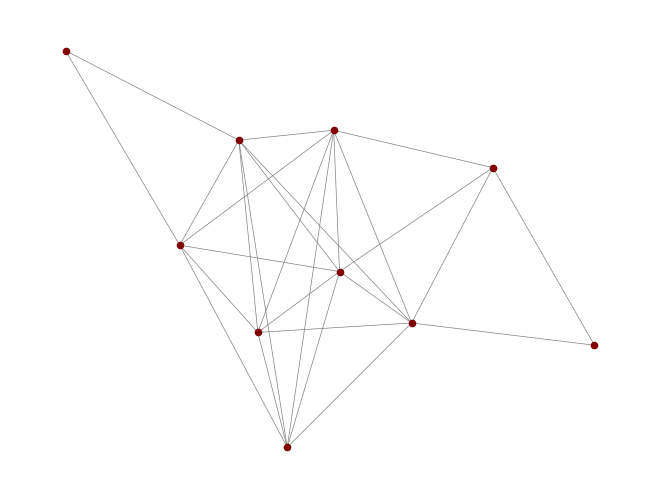

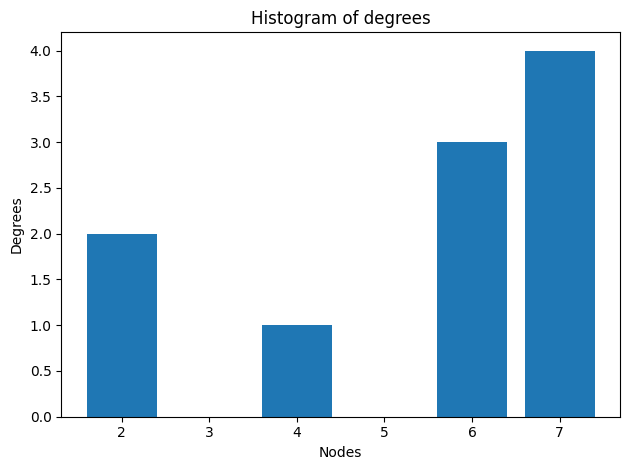

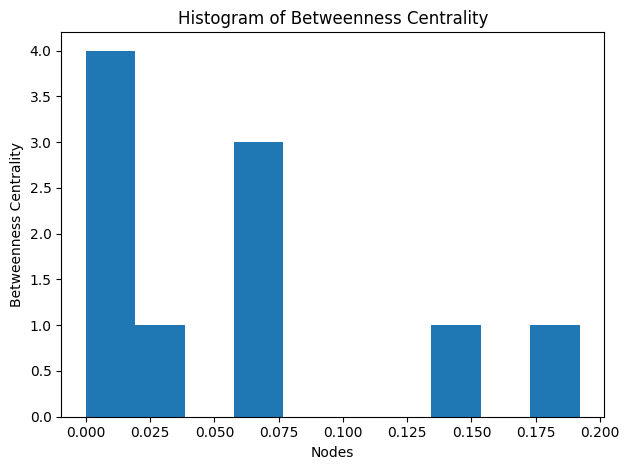

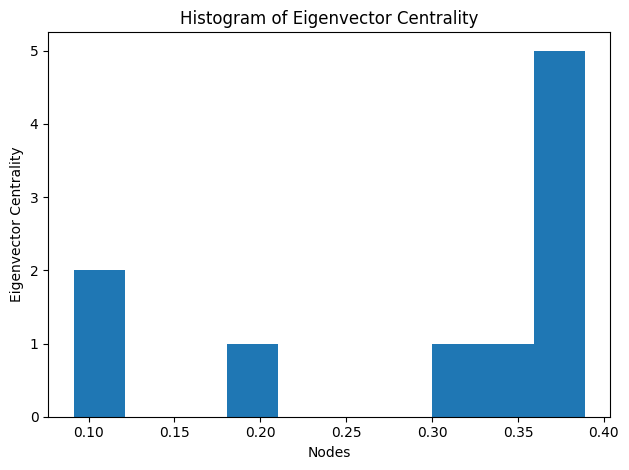

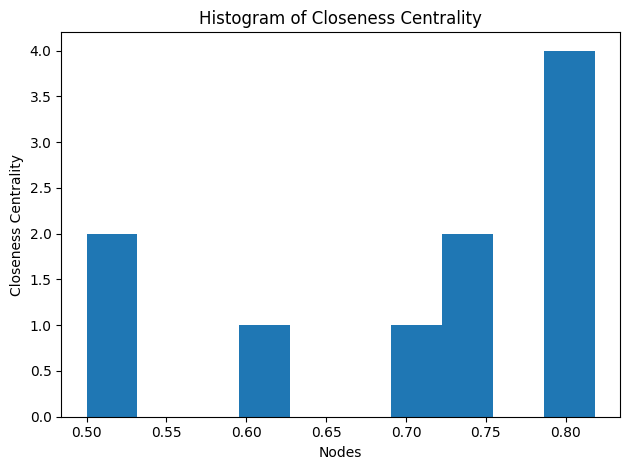


Global Summaries
Diameter :  3
Number of Nodes :  27
Number of Edges :  10
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  10

 CIRCLE1 



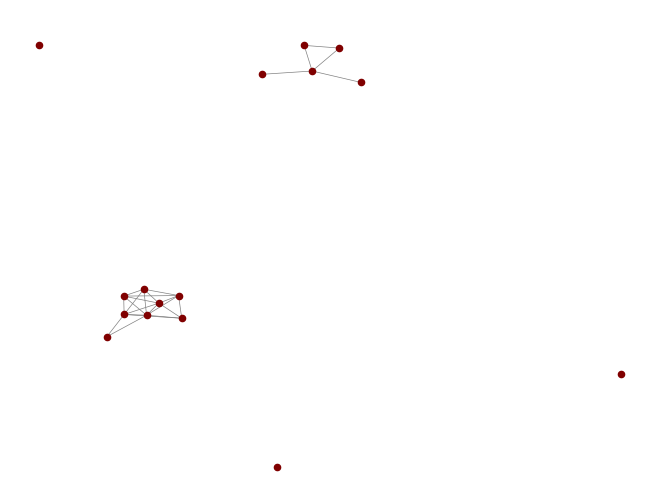

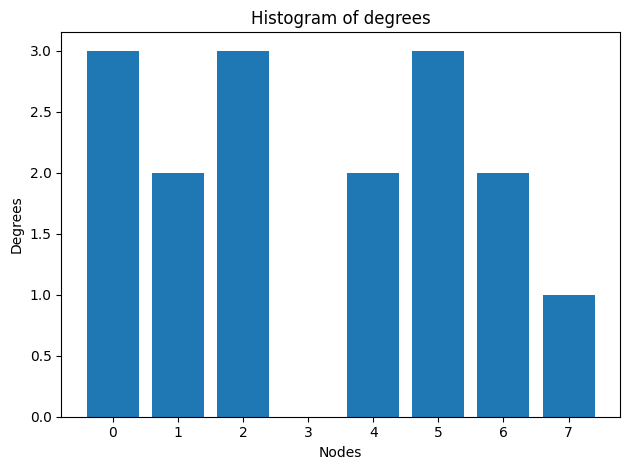

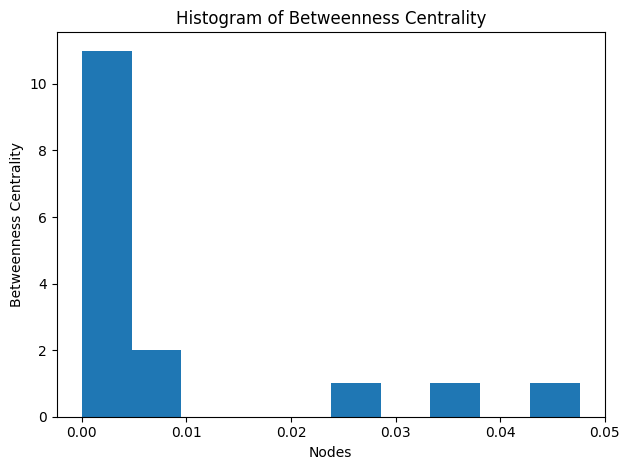

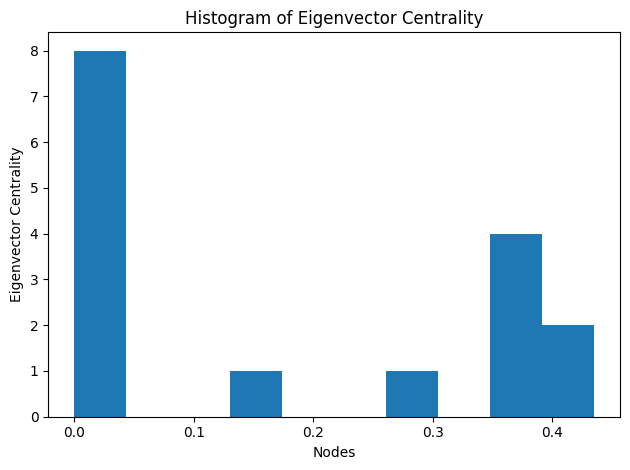

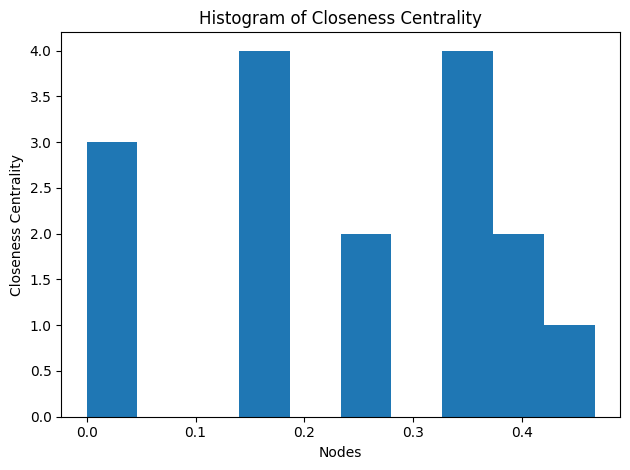


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  25
Number of Edges :  16
Number of Connected Components :  5
Size of the Largest Connected Compopnent :  8

 CIRCLE2 



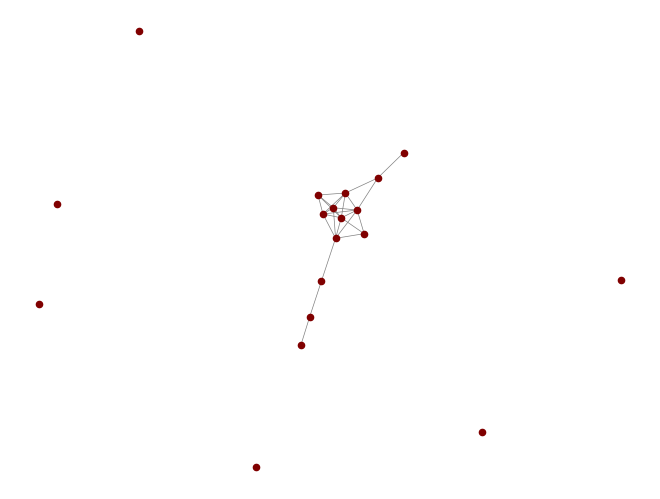

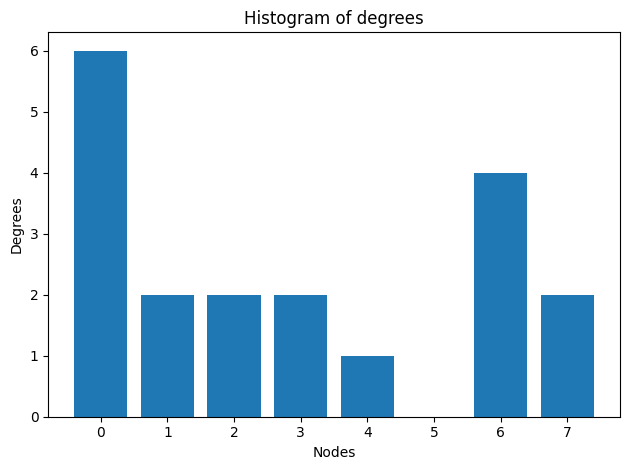

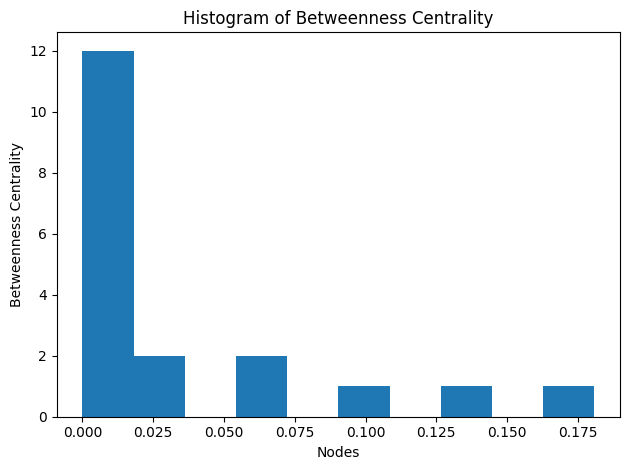

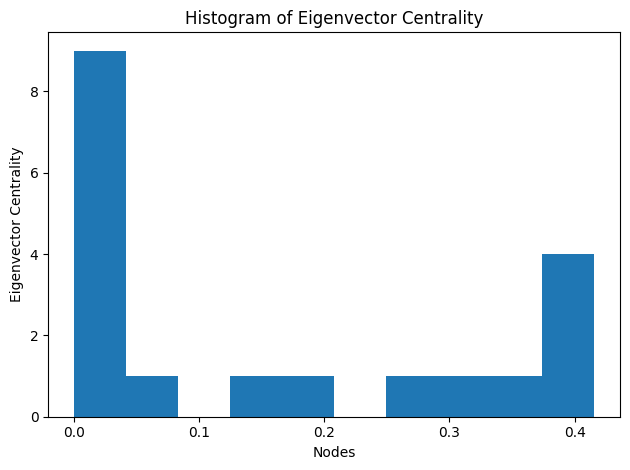

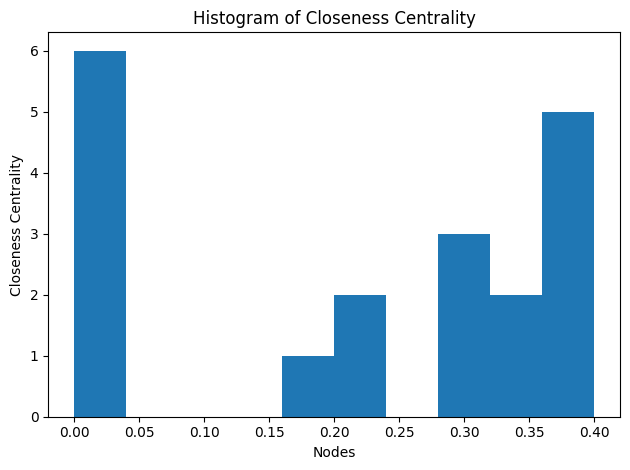


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  27
Number of Edges :  19
Number of Connected Components :  7
Size of the Largest Connected Compopnent :  13

 CIRCLE3 



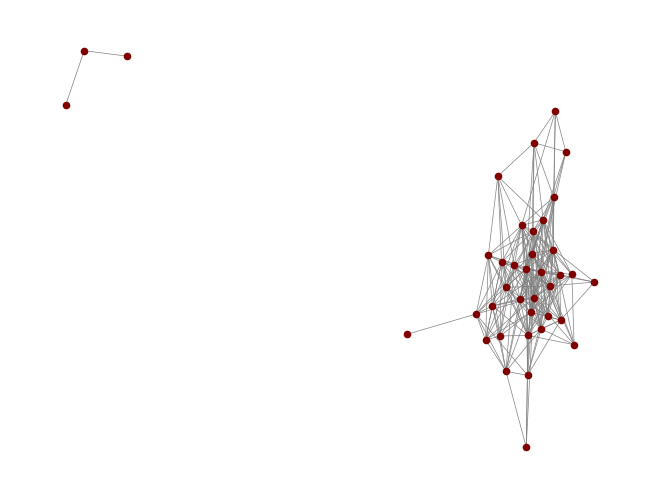

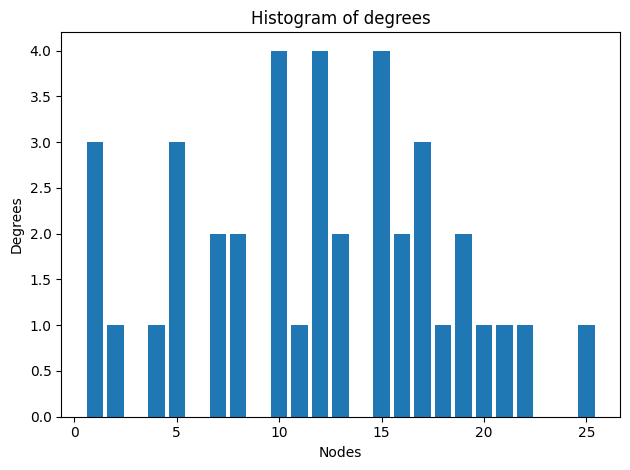

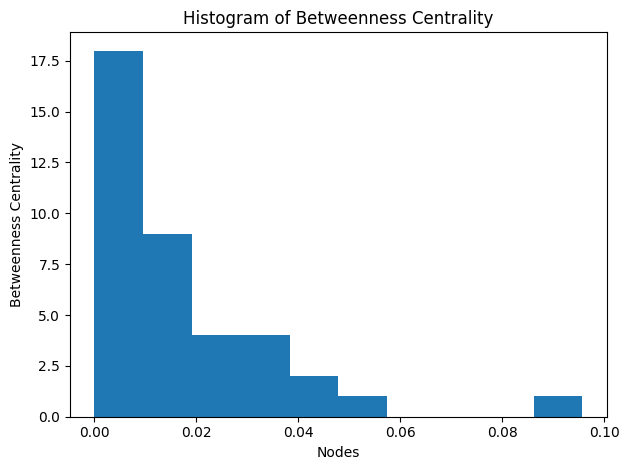

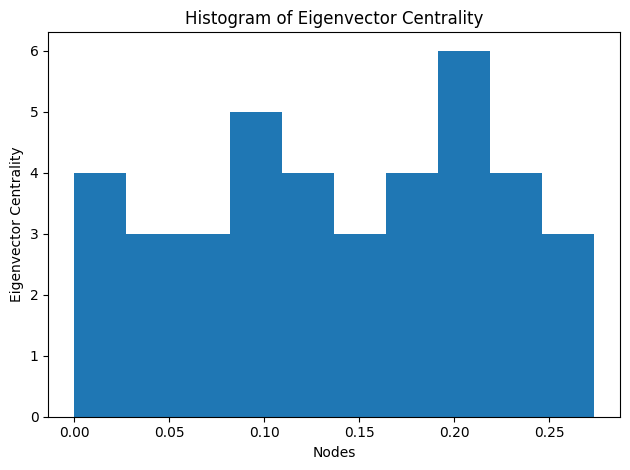

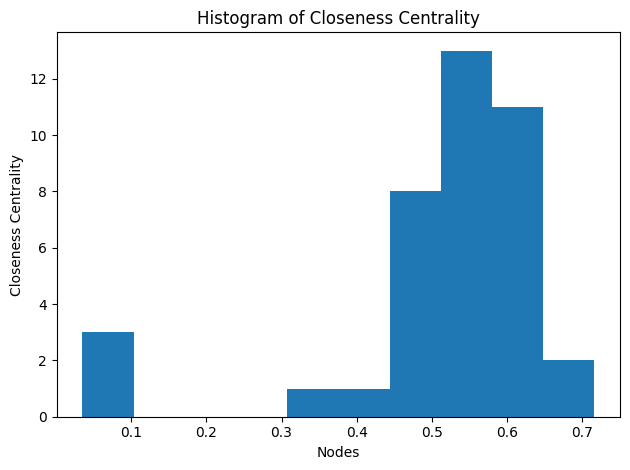


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  233
Number of Edges :  39
Number of Connected Components :  2
Size of the Largest Connected Compopnent :  36

 CIRCLE4 



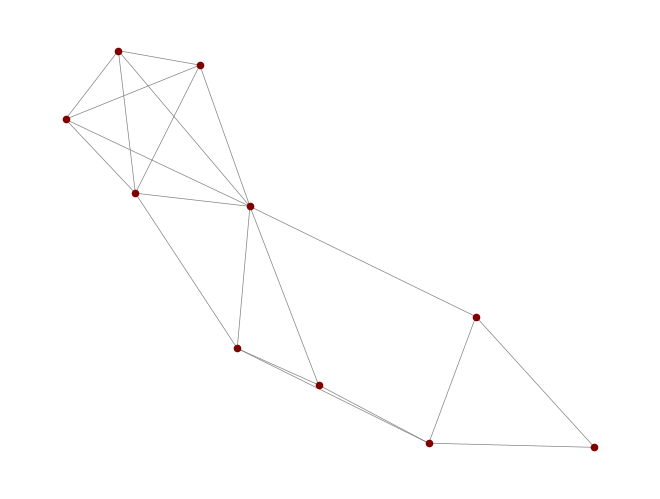

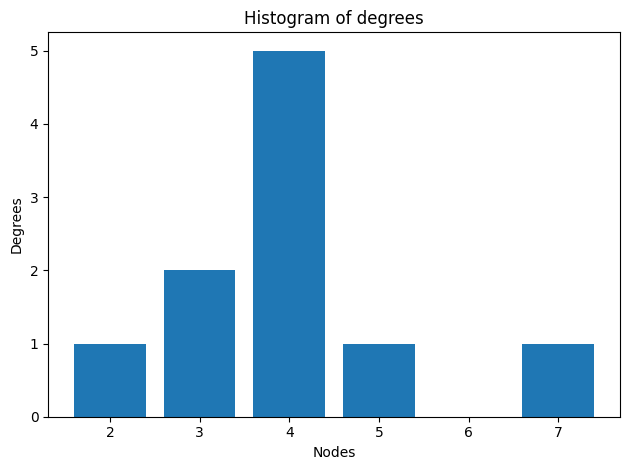

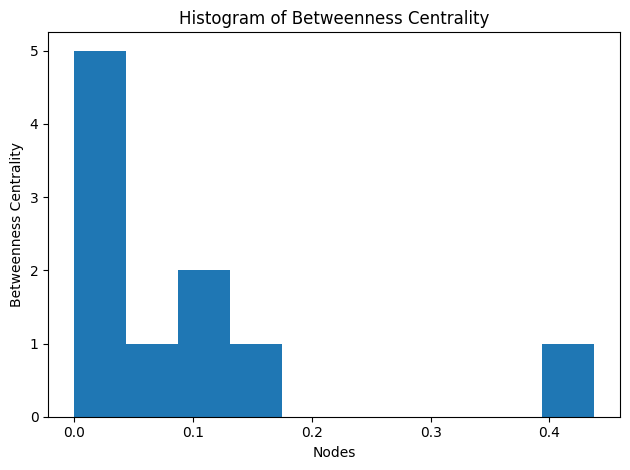

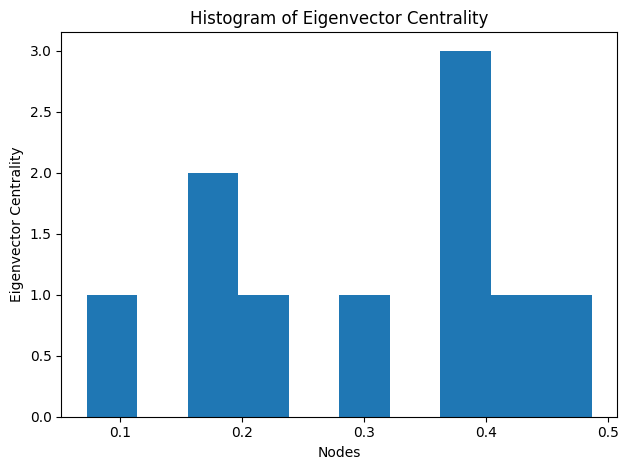

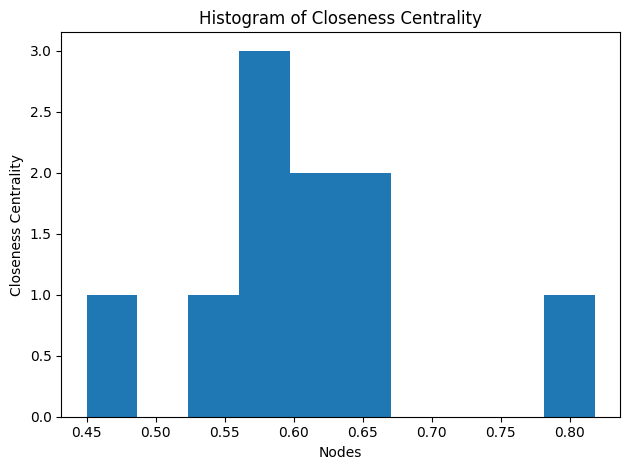


Global Summaries
Diameter :  3
Number of Nodes :  20
Number of Edges :  10
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  10

 CIRCLE5 



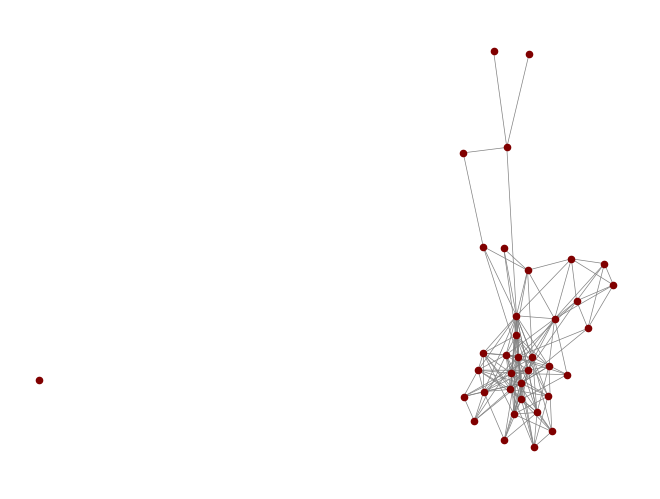

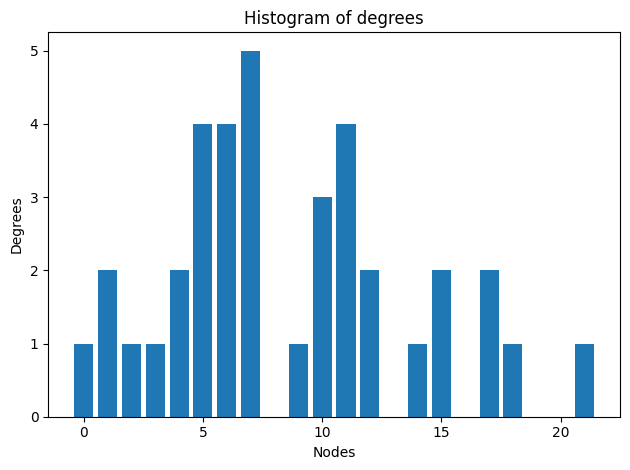

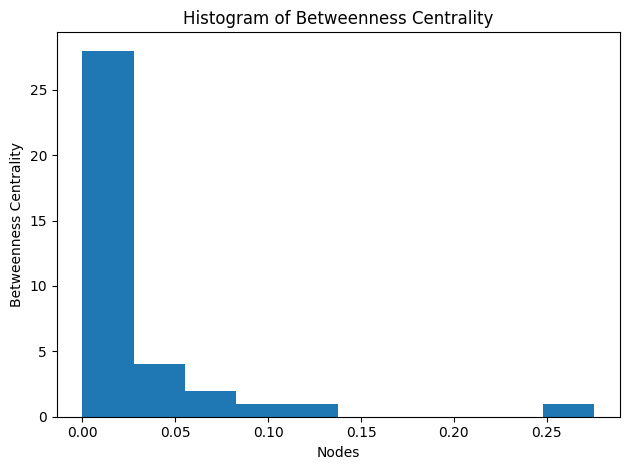

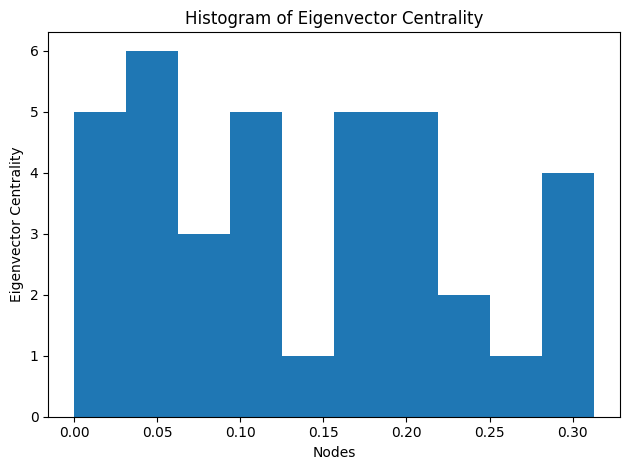

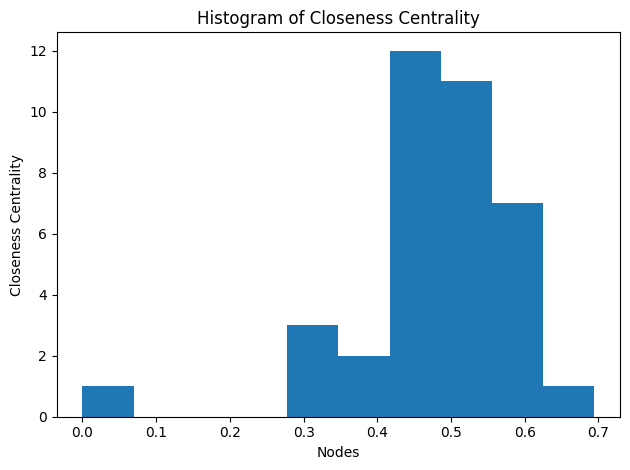


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  159
Number of Edges :  37
Number of Connected Components :  2
Size of the Largest Connected Compopnent :  36

 CIRCLE6 



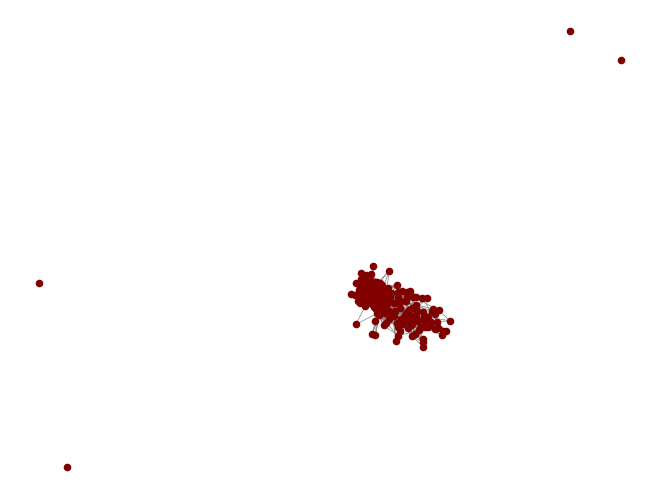

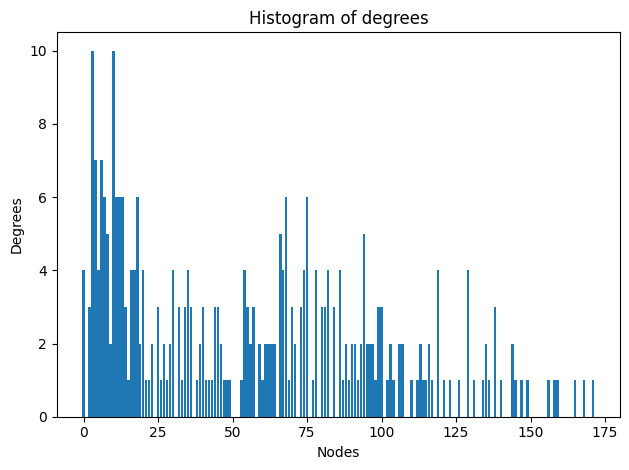

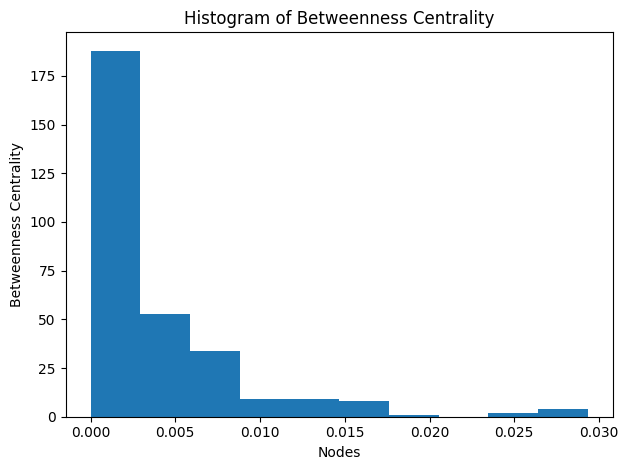

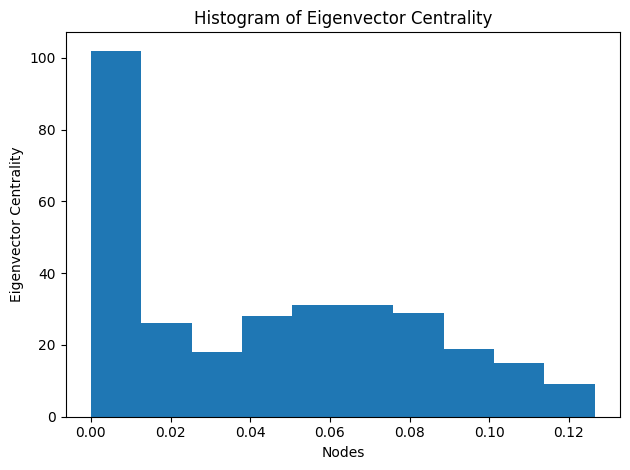

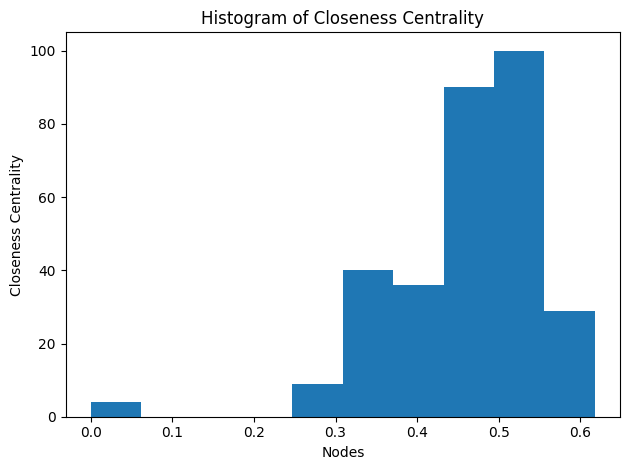


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  8612
Number of Edges :  308
Number of Connected Components :  5
Size of the Largest Connected Compopnent :  304

 CIRCLE7 



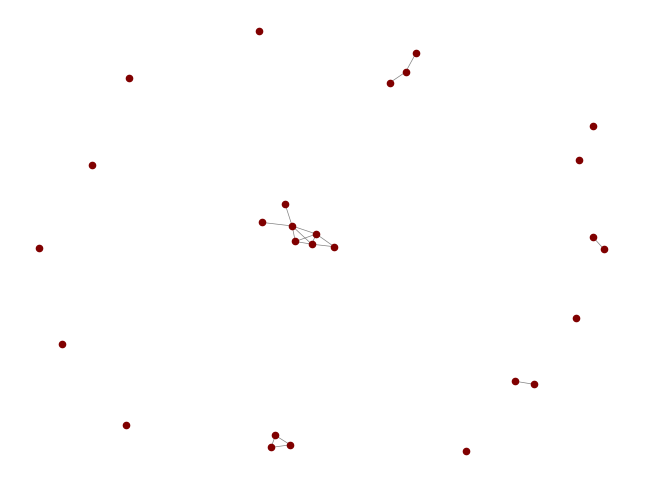

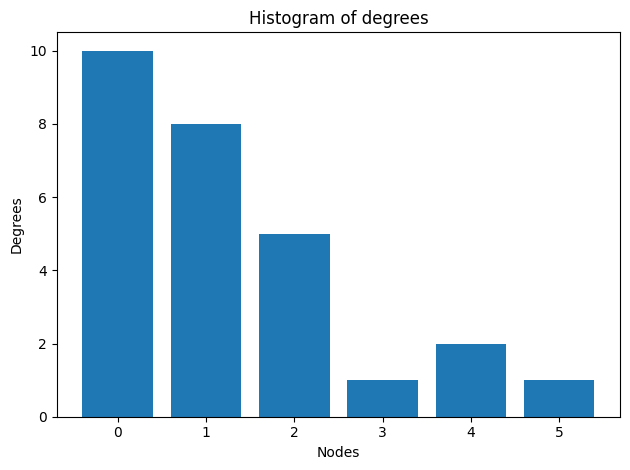

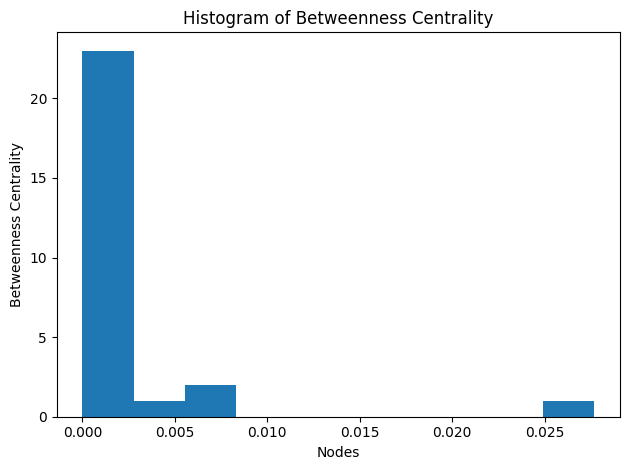

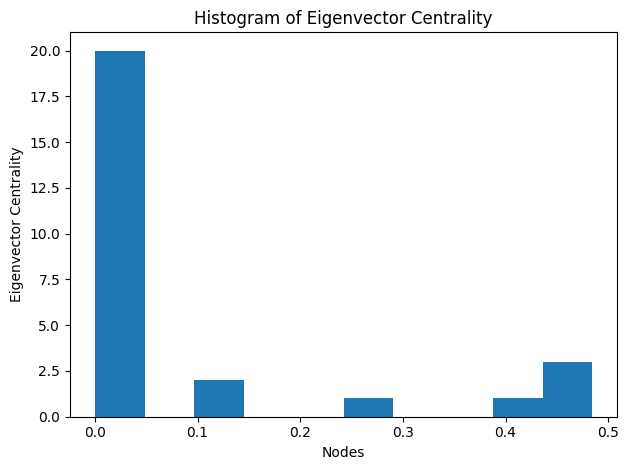

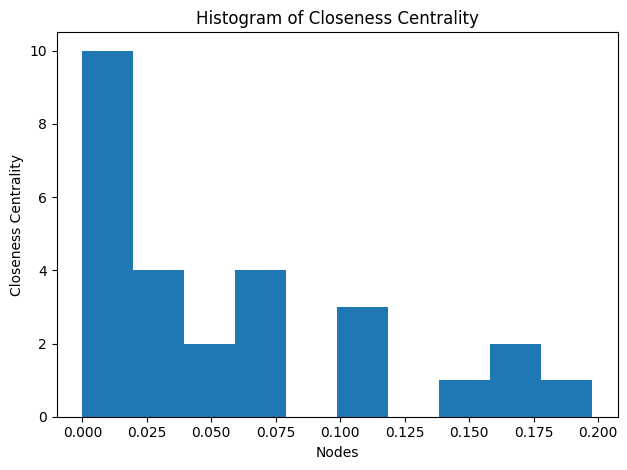


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  17
Number of Edges :  27
Number of Connected Components :  15
Size of the Largest Connected Compopnent :  7

 CIRCLE8 



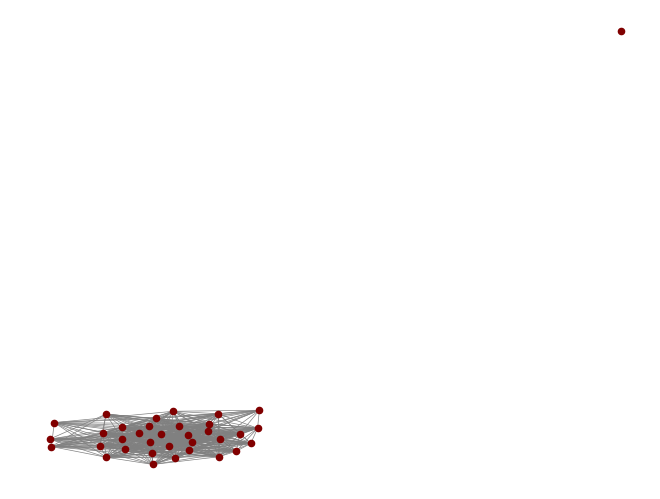

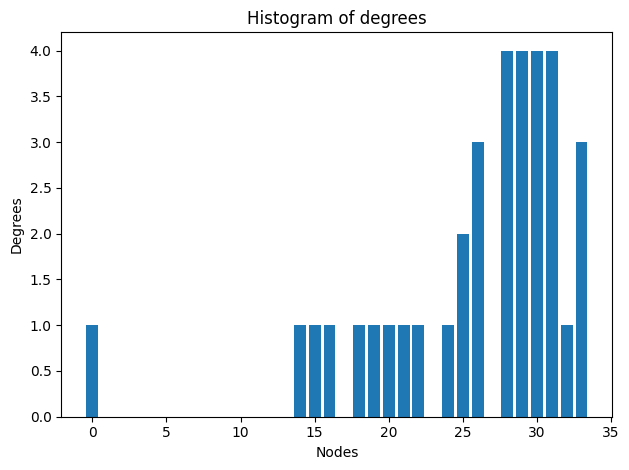

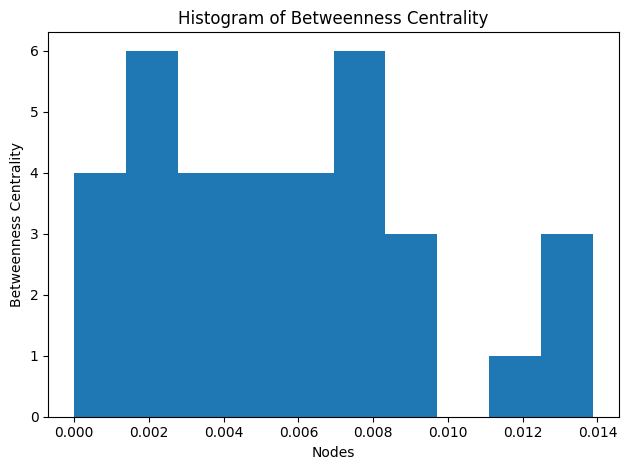

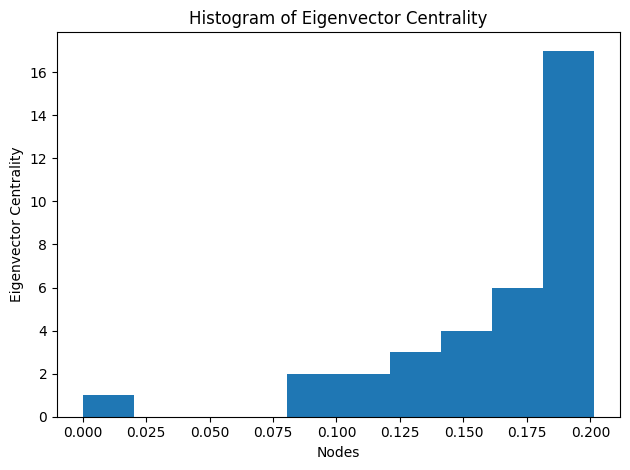

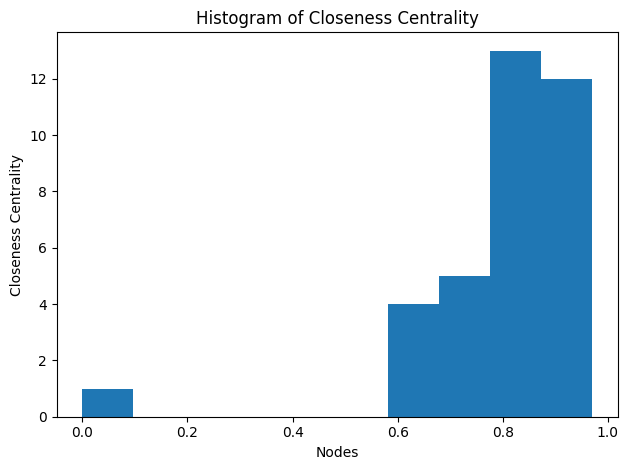


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  450
Number of Edges :  35
Number of Connected Components :  2
Size of the Largest Connected Compopnent :  34


In [ ]:
circles_107 = read_circles(circles_107)
for c in circles_107:
    print("\n",c.upper(),"\n")
    explore_and_summarize_network(edgelist = list(G_107.edges()), vertices=list(G_107.nodes()), subgraph=circles_107[c])

## Discussions :

Circle0 and circle4 have similar network plots. Also circle6 and circle 8 have similar pattern with one connected graph and few seperate nodes. Finally, circle1 and circle7 have quite similar network structure. All of the circles have different node number and edge numbers. Diameters of some not connected graphs could not calculated with provided function.

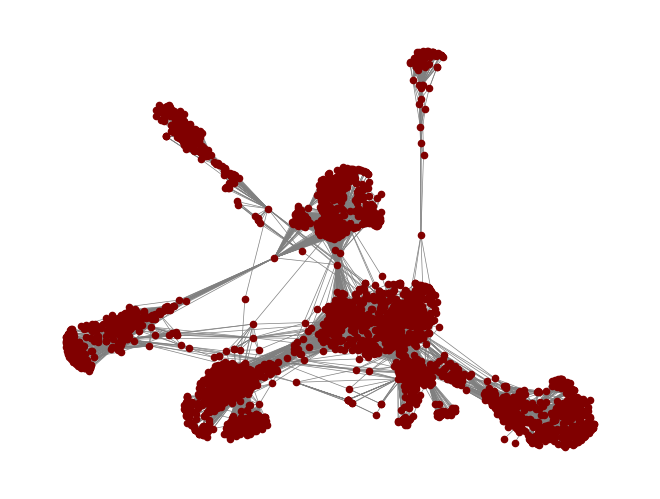

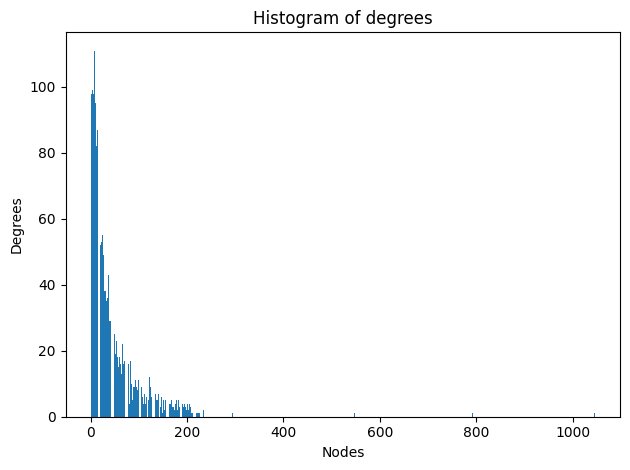

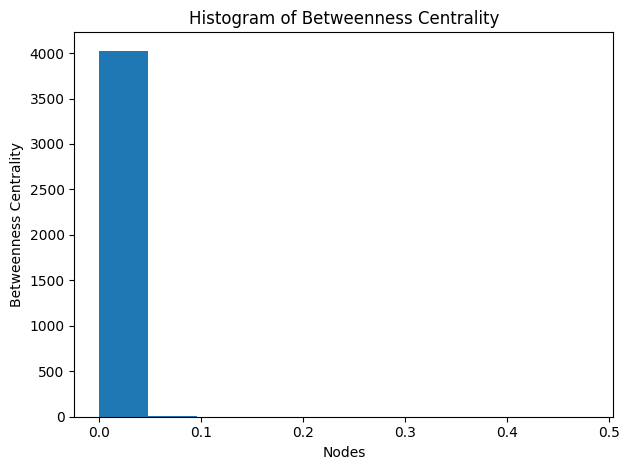

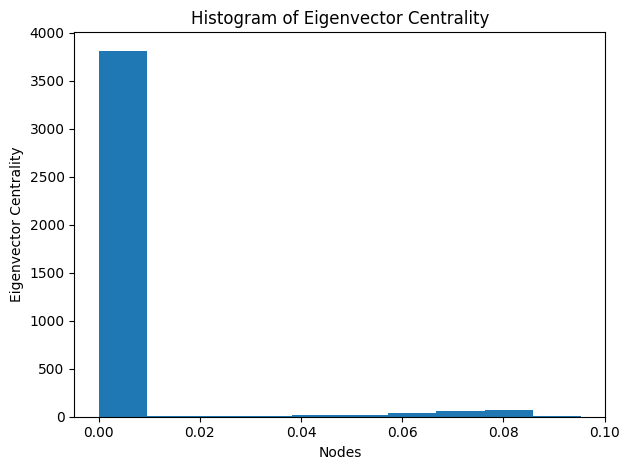

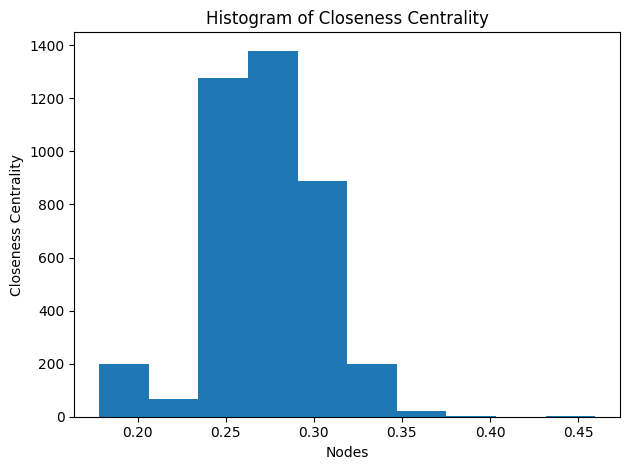


Global Summaries
Diameter :  8
Number of Nodes :  88234
Number of Edges :  4039
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  4039


In [ ]:
explore_and_summarize_network(edgelist = G_combined.edges(), vertices=G_combined.nodes(),
                              subgraph=None)

In [ ]:
def degrees_of_separation(G, max_iter = 1000):
    shortest_paths = []
    for _ in range(max_iter):
        rand_two = random.sample(list(G.nodes), 2)
        shortest_paths.append(nx.shortest_path_length(G,rand_two[0], rand_two[1]))
    fig, ax = plt.subplots()
    ax.hist(shortest_paths, color = "orange")
    ax.set_xlabel('Lengths')
    ax.set_ylabel('Shortest Path')
    ax.set_title('The Distribution of the 1000 Shortest Path Lengths')
    plt.show()
    print("\nMean : ",statistics.mean(shortest_paths))

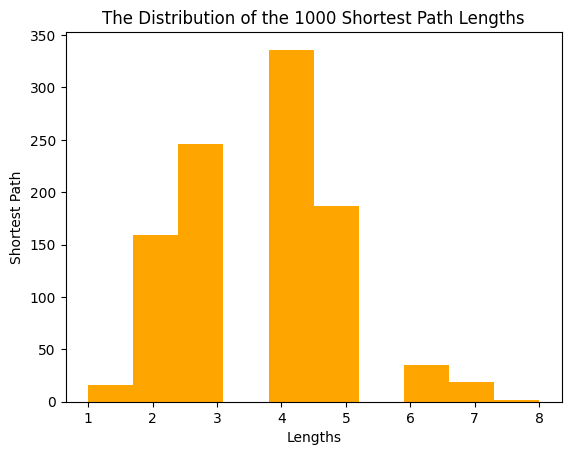


Mean :  3.71


In [ ]:
degrees_of_separation(G_combined)

Above distribution and mean are close to the results shown in the slides. Since mean is 3.7 it is close to the 3.57 . It looks like facebook social networks getting bigger and people are gettin closer year by year.

# **4. Community Detection**

A community is a group of people who are homogeneous in some features. Marketers want to find communities so that they can target them. It is not trivial to identify communities from a given network.

Community detection deals with identifying networks based only on the network topology. Nodes in the community are closer than the nodes outside the community. What is closeness? To define closeness, we need to
1. Define distance metric based on network topology
2. Quantify nodes in a community are closer with each other than nodes outside the community

There are two approaches, bottom-up and top-down.

## Girvan Newman Algorithm:

The most popular algorithm for network community detection is the `Girvan-Newman algorithm`. It is a top-down approach where we take the whole network and try to break it into multiple communities. This can be continued till the bottom.
Steps:
1. Define betweenness measure for each edge
2. Find the edge with maximum betweenness and remove it (The edge most in-between in the network connects up most number of pairs of nodes)
3. Recalculate and repeat

In [ ]:
def girvan_newman(G, no_of_components_to_split):
    while(no_of_components_to_split > nx.algorithms.components.number_connected_components(G)):
        # Calculate the betweenness centrality
        btw_centrality = nx.algorithms.centrality.edge_betweenness_centrality(G)
        # sort based on betweenness centrality
        sorted_edges = sorted(btw_centrality.items(), key = lambda item:item[1], reverse = True)[0]
        print('\nRemoving the edge', sorted_edges)
        # remove edge which has highest centrality
        G.remove_edge(*sorted_edges[0])

    # Check if graph is split
    if(no_of_components_to_split <= nx.algorithms.components.number_connected_components(G)):
        # Plot the graph with both the nodes having different colors
        nx.draw_spring(G, with_labels=False)
        # return list of nodes in each community
        list_of_nodes = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
        return list_of_nodes

In [ ]:
def girvan_newman_club(G,communities):
    colors_for_edges = [(np.random.random(1)[0],np.random.random(1)[0],np.random.random(1)[0]) for i in range(len(communities))]
    for i, nodes in enumerate(communities):
        for node in nodes:
            G.add_node(node,node_color = colors_for_edges[i])
    nx.draw_kamada_kawai(G, node_size=50, edge_color="gray", node_color = list(nx.get_node_attributes(G,'node_color').values()))

## Ratio cut method
A more complex and advanced method is the ratio cut method. A cut in a graph is a set of edges, such that if we remove them, the network breaks up into two components. The procedure is as follows:
1. Find the minimum cut among all the pair of nodes
2. Repeat over each of the two parts cut

The minimum cut can be found using Ratio Cut parameter. Minimum cut will have the least ratio cut among all the other cuts.

This can be done quickly using an inbuilt function in NetworkX




In [ ]:
def radio_cut_method(G):
    communities = community.kernighan_lin_bisection(G, max_iter=100)
    pos = nx.spring_layout(G)
    nx.draw(G,pos, node_size =100, node_color='w', node_shape = '.')
    colors = [(np.random.random(1)[0],np.random.random(1)[0],np.random.random(1)[0]) for i in range(len(communities))]

    for i in range(len(communities)):
        nx.draw_networkx_nodes(G, pos, nodelist=communities[i], node_size=50, node_color=colors[i])

In [ ]:
def get_circle_labels(G,circles):
    circle_labels = []
    for node in G.nodes():
        is_added = False
        for i,li in enumerate(list(circles.values())):
            if node in li and not is_added:
                circle_labels.append(i)
                is_added = True
        if not is_added:
            circle_labels.append(-1)
    return circle_labels

In [ ]:
def get_community_labels(G, communities):
    community_labels = []
    for node in G.nodes():
        is_added = False
        for i,li in enumerate(communities):
            if node in li and not is_added:
                community_labels.append(i)
                is_added = True
        if not is_added:
            community_labels.append(-1)
    return community_labels

In [ ]:
def explore_and_summarize_network_v2(edgelist, vertices, subgraph, directed=False, circles=None):
    """
    Concisely summarizes any induced subgraph of the input network
    """
    G = nx.Graph()
    if subgraph is not None:
        induced_edges = [ edge for edge in edgelist if ((edge[0] in subgraph) and (edge[1] in subgraph))]
        G.add_nodes_from(subgraph)
        G.add_edges_from(induced_edges, nodetype=int)
    else :
        G.add_nodes_from(vertices)
        G.add_edges_from(edgelist, nodetype=int)

    # local_summaries

    betweenness_centrality = nx.centrality.betweenness_centrality(G)
    max_betweenness_centrality_node = max(betweenness_centrality, key=betweenness_centrality.get)
    eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
    max_eigenvector_centrality = max(eigenvector_centrality, key=eigenvector_centrality.get)
    closeness_centrality = nx.centrality.closeness_centrality(G)
    max_closeness_centrality = max(closeness_centrality, key=closeness_centrality.get)

    # (a)
    if directed:
        in_degrees = [G.in_degree(n) for n in G.nodes]
        in_degree_dict= {n:G.degree(n) for n in G.nodes}
        max_in_degree = max(max_in_degree, key=max_in_degree.get)
        out_degrees = [G.in_degree(n) for n in G.nodes]
        out_degree_dict= {n:G.degree(n) for n in G.nodes}
        max_out_degree = max(out_degree_dict, key=out_degree_dict.get)
        reciprocity = nx.algorithms.reciprocity(G)
        mean_reciprocity = [value for key,value in nx.algorithms.reciprocity(G)].mean()

        in_degree_counts = Counter(in_degrees)
        fig, ax = plt.subplots()
        ax.bar(in_degree_counts.keys(), in_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('In Degrees')
        ax.set_title(r'Histogram of in_degrees')
        fig.tight_layout()
        plt.show()

        out_degree_counts = Counter(out_degrees)
        fig, ax = plt.subplots()
        ax.bar(out_degree_counts.keys(), out_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of out_degrees')
        fig.tight_layout()
        plt.show()

        reciprocity_counts = Counter(reciprocity)
        fig, ax = plt.subplots()
        ax.bar(reciprocity_counts.keys(), reciprocity_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of Reciprocity')
        fig.tight_layout()
        plt.show()
    else:
        degrees =[G.degree(n) for n in G.nodes]
        degree_counts = Counter(degrees)
        fig, ax = plt.subplots()
        ax.bar(degree_counts.keys(), degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('Degrees')
        ax.set_title(r'Histogram of degrees')
        fig.tight_layout()
        plt.show()


    # (c)
    fig1, ax1 = plt.subplots()
    ax1.hist(list(betweenness_centrality.values()))
    ax1.set_xlabel('Nodes')
    ax1.set_ylabel('Betweenness Centrality')
    ax1.set_title(r'Histogram of Betweenness Centrality')
    fig1.tight_layout()
    plt.show()

    # (d)
    fig2, ax2 = plt.subplots()
    ax2.hist(list(eigenvector_centrality.values()))
    ax2.set_xlabel('Nodes')
    ax2.set_ylabel('Eigenvector Centrality')
    ax2.set_title(r'Histogram of Eigenvector Centrality')
    fig2.tight_layout()
    plt.show()

    # (e)
    fig3, ax3 = plt.subplots()
    ax3.hist(list(closeness_centrality.values()))
    ax3.set_xlabel('Nodes')
    ax3.set_ylabel('Closeness Centrality')
    ax3.set_title(r'Histogram of Closeness Centrality')
    fig3.tight_layout()
    plt.show()

    # Print Global Summaries
    global_summaries_v2(G)

In [ ]:
def global_summaries_v2(G):
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
    except:
        diameter = "Found infinite path length because the graph is not connected !"
    clustering_coefficient = nx.algorithms.approximation.clustering_coefficient.average_clustering(G)
    number_of_nodes = G.number_of_edges()
    number_of_edges = G.number_of_nodes()
    number_of_connected_components = nx.number_connected_components(G)
    largest_connected_component = max([ len(i) for i in list(nx.connected_components(G))])
    print("\nGlobal Summaries")
    print("Diameter : ",diameter)
    print("Number of Nodes : ",number_of_nodes)
    print("Number of Edges : ",number_of_edges)
    print("Number of Connected Components : ",number_of_connected_components)
    print("Size of the Largest Connected Compopnent : ",largest_connected_component)

## Random Graph generated for validating

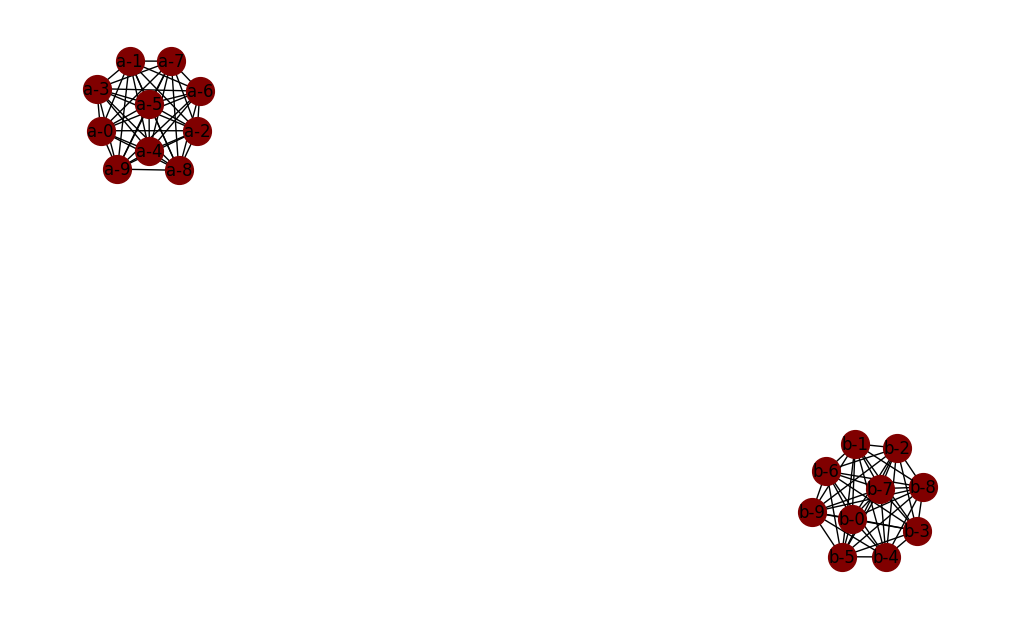

In [ ]:
G_random1 = nx.complete_graph(10)
G_random2 = nx.complete_graph(10)

G = nx.union(G_random1, G_random2, rename=('a-', 'b-'))


plt.figure(figsize=(10,6))

nx.draw(G, node_color='pink',
        with_labels=True,
        node_size=40)

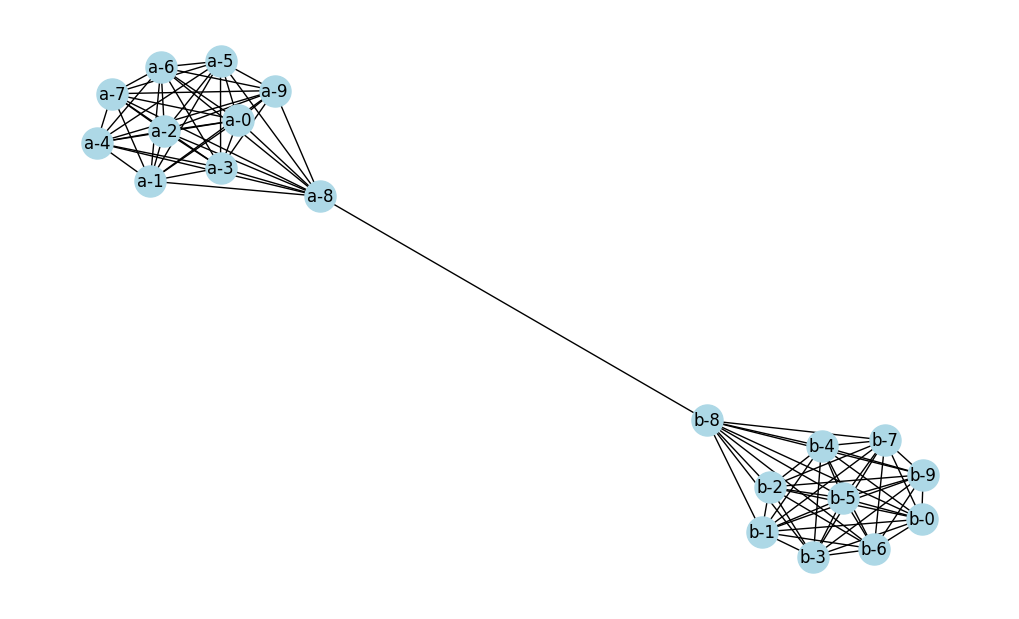

In [ ]:
G.add_edge('b-8', 'a-8')

plt.figure(figsize=(10,6))

nx.draw(G, node_color='lightblue',
        with_labels=True,
        node_size=500)

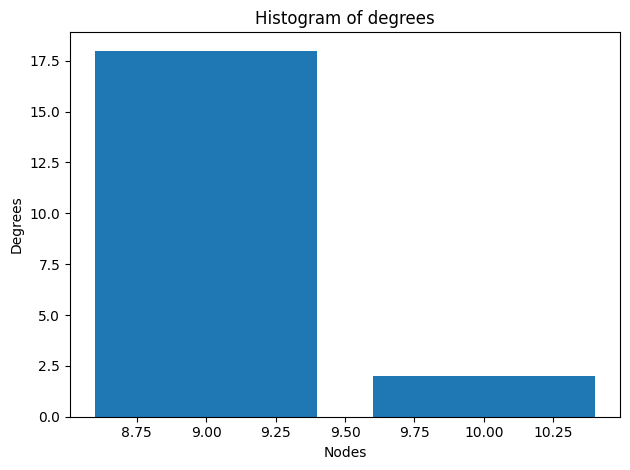

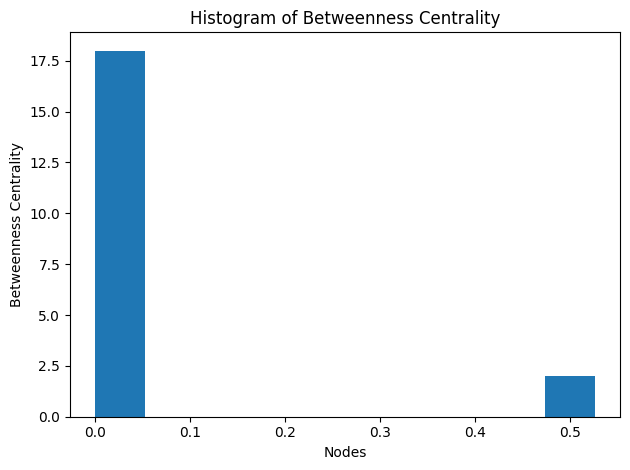

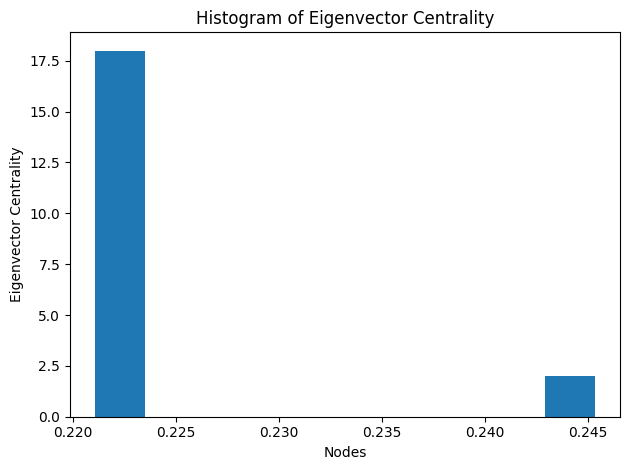

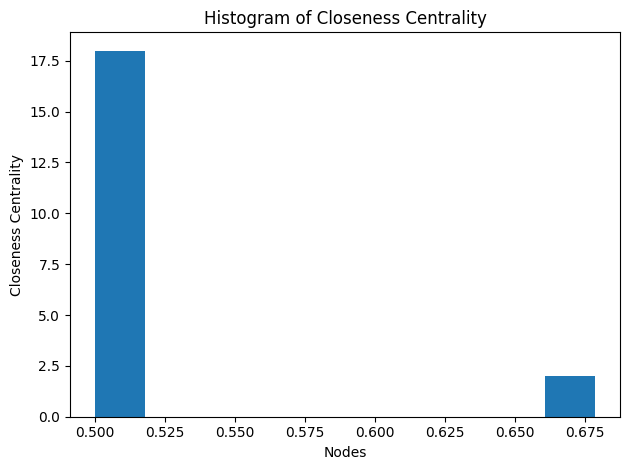


Global Summaries
Diameter :  3
Number of Nodes :  91
Number of Edges :  20
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  20


In [ ]:
explore_and_summarize_network_v2(edgelist = G.edges(), vertices=G.nodes(), subgraph=None)




communities [{'a-3', 'a-2', 'a-6', 'a-7', 'a-5', 'a-4', 'a-0', 'a-8', 'a-1', 'a-9'}, {'b-2', 'b-0', 'b-1', 'b-6', 'b-8', 'b-5', 'b-7', 'b-4', 'b-9', 'b-3'}]


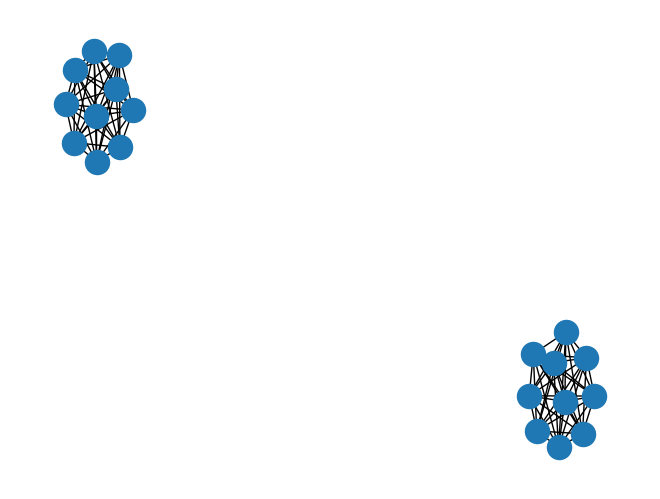

In [ ]:
print('\n\ncommunities')
for c in communities:
  print('\n',c)

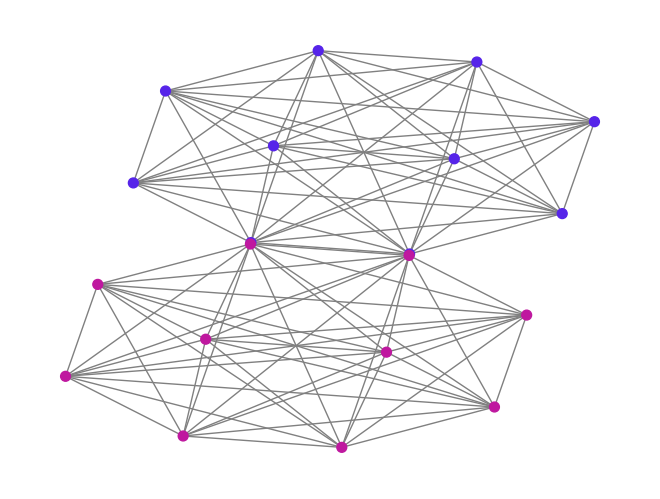

In [ ]:
girvan_newman_club(G,communities)

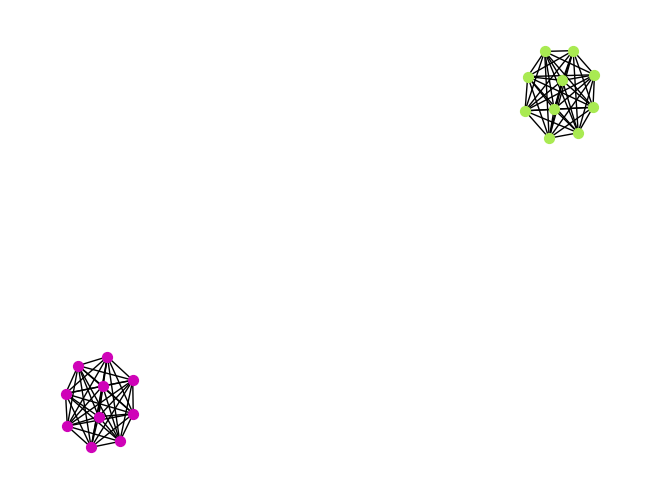

In [ ]:
radio_cut_method(G)

The above function ran on the ego networks for nodes 0 and 107, making sure to get communities from the Girvan-Newman algorithm. Now, let’s assess how closely the identified communities from community detection match the social circles defined for the graph.


**Below visualizations applied in the notebook:**

*   Plotted the network via the force-directed layout twice. In one plot, color the nodes according to the identified communities. In the other plot, color the nodes according to the social circle labels identified in the .circles files.

  **Note** - there may be overlap among the circles.

*   Calculated the adjusted rand score to gauge the similarity between the cluster labels and the social circle labels for each vert

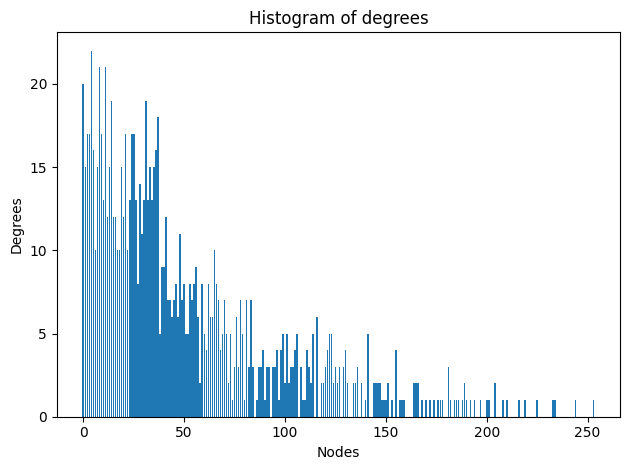

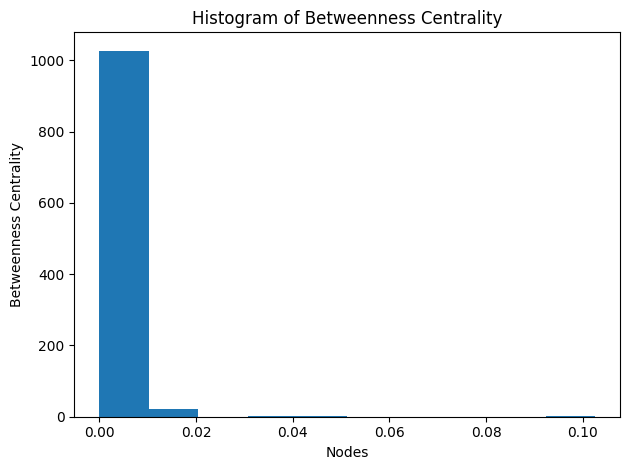

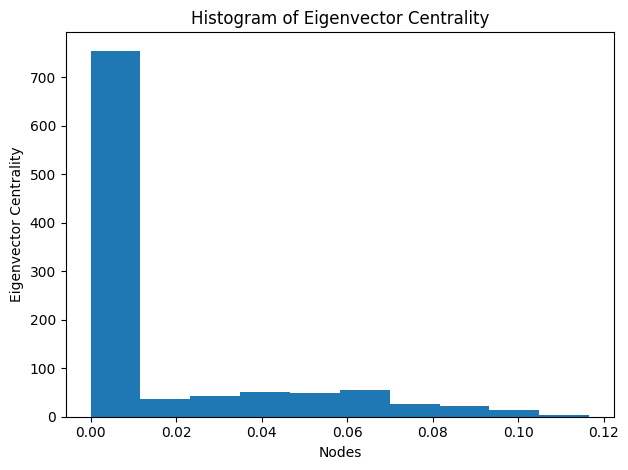

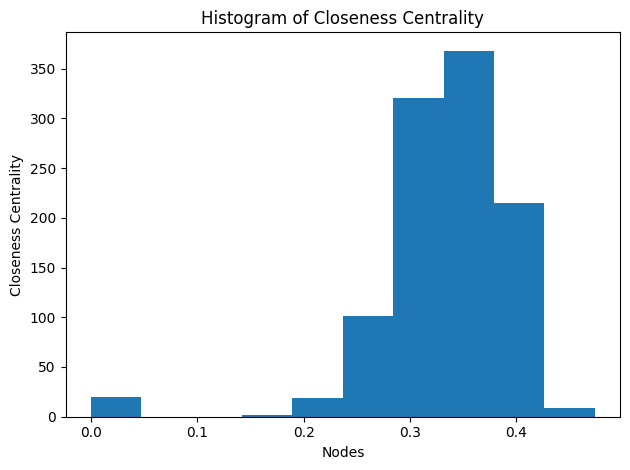


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  26749
Number of Edges :  1054
Number of Connected Components :  21
Size of the Largest Connected Compopnent :  1034


In [ ]:
explore_and_summarize_network_v2(edgelist = G_107.edges(), vertices=G_107.nodes(), subgraph=None, circles=circles_107)



Removing the edge ((1086, 917), 0.012774881442306927)

Removing the edge ((1467, 1371), 0.013388817556217474)

Removing the edge ((1703, 1584), 0.012711493579699697)

Removing the edge ((1091, 1890), 0.011549242502260977)

Removing the edge ((1235, 1086), 0.009427973675139114)

Removing the edge ((1192, 1086), 0.009389002017875627)

Removing the edge ((1298, 1086), 0.009254960226882034)

Removing the edge ((1680, 1086), 0.009280737000863324)

Removing the edge ((1086, 1715), 0.010592985002233334)

Removing the edge ((1086, 1423), 0.011838601555405809)

Removing the edge ((927, 1611), 0.010433923010997376)

Removing the edge ((1060, 1086), 0.010158484305598708)

Removing the edge ((921, 1404), 0.009886488917459682)

Removing the edge ((1021, 1334), 0.01025987347844673)

Removing the edge ((483, 1086), 0.00923419258797454)

Removing the edge ((1424, 1339), 0.008279097249203995)

Removing the edge ((1366, 1584), 0.007939148015327725)

Removing the edge ((1086, 1032), 0.007913351277659084

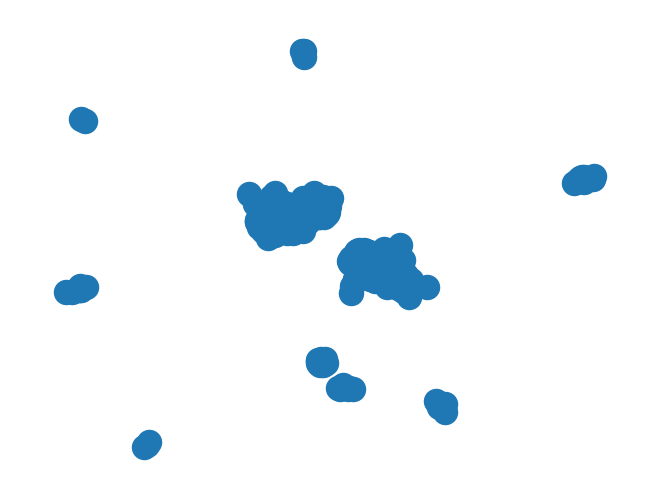

In [ ]:
communities = girvan_newman(G_107,10)
print('\n\ncommunities')
for c in communities:
  print('\n',c)

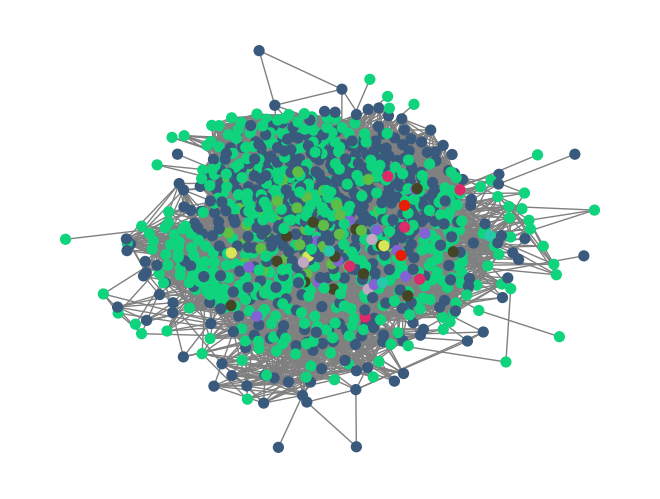

In [ ]:
girvan_newman_club(G_107,communities)

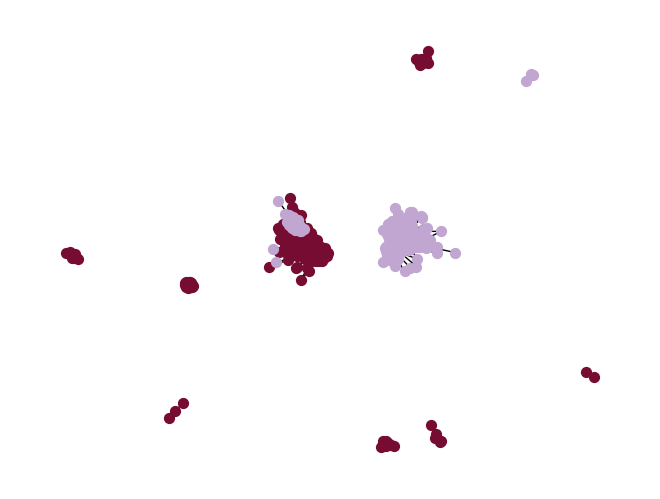

In [ ]:
radio_cut_method(G_107)

In [ ]:
adjusted_rand_score(get_community_labels(G_107, communities), get_circle_labels(G_107, circles_107))


0.0010857311623432766

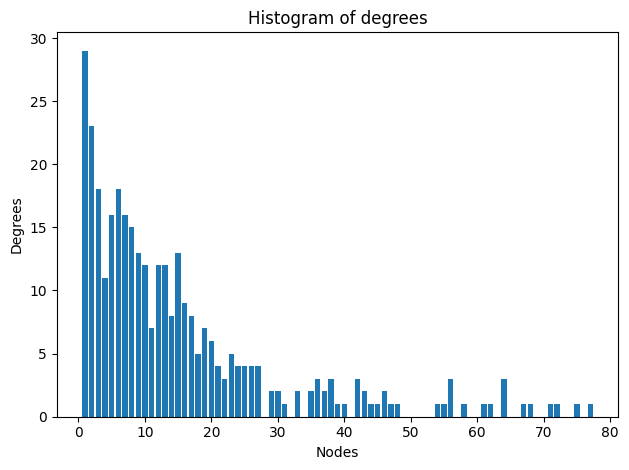

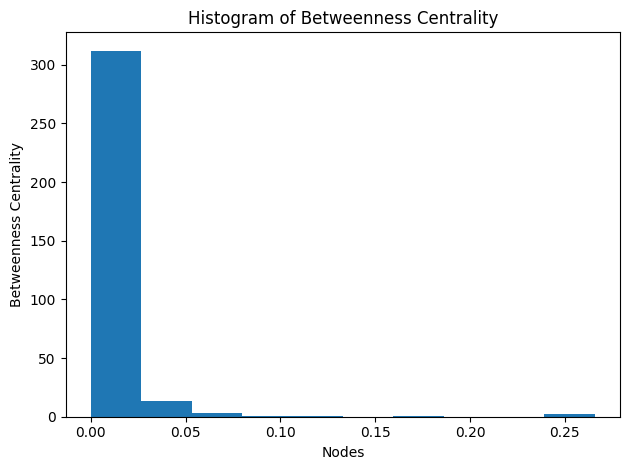

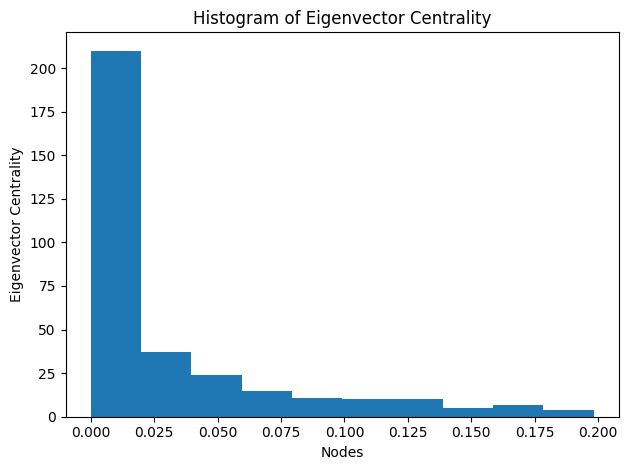

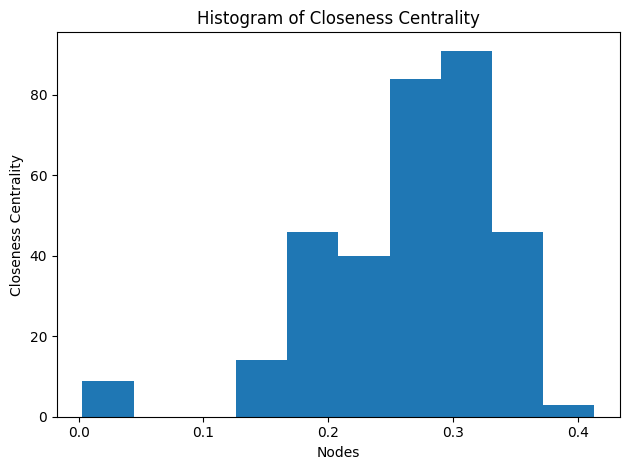


Global Summaries
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  2519
Number of Edges :  333
Number of Connected Components :  5
Size of the Largest Connected Compopnent :  324


In [ ]:
circles_0 = read_circles(circles_0)
explore_and_summarize_network_v2(edgelist = G_0.edges(), vertices=G_0.nodes(), subgraph=None, circles=circles_0)



communities [{1, 3, 5, 7, 9, 10, 13, 16, 21, 22, 24, 25, 26, 27, 29, 30, 31, 36, 38, 39, 40, 45, 47, 48, 50, 51, 53, 54, 55, 56, 57, 59, 60, 62, 63, 64, 65, 66, 67, 69, 72, 73, 75, 76, 77, 79, 80, 82, 83, 84, 85, 87, 88, 92, 94, 96, 98, 100, 101, 103, 104, 105, 106, 108, 109, 113, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 139, 141, 142, 146, 148, 150, 153, 156, 158, 159, 160, 161, 163, 164, 165, 168, 169, 170, 171, 172, 176, 178, 180, 183, 184, 185, 186, 187, 188, 189, 190, 191, 194, 196, 197, 199, 200, 203, 204, 206, 207, 208, 211, 212, 213, 217, 221, 222, 223, 224, 228, 229, 231, 232, 234, 235, 236, 237, 238, 239, 242, 246, 247, 248, 249, 250, 251, 252, 254, 257, 258, 260, 261, 265, 266, 268, 270, 271, 272, 274, 276, 277, 280, 281, 283, 284, 285, 288, 290, 291, 294, 295, 297, 298, 299, 300, 301, 302, 303, 304, 308, 309, 311, 313, 314, 315, 316, 317, 318, 320, 322, 323, 324, 325, 329, 330, 331, 332, 334, 336, 338, 339, 340, 341, 342, 3

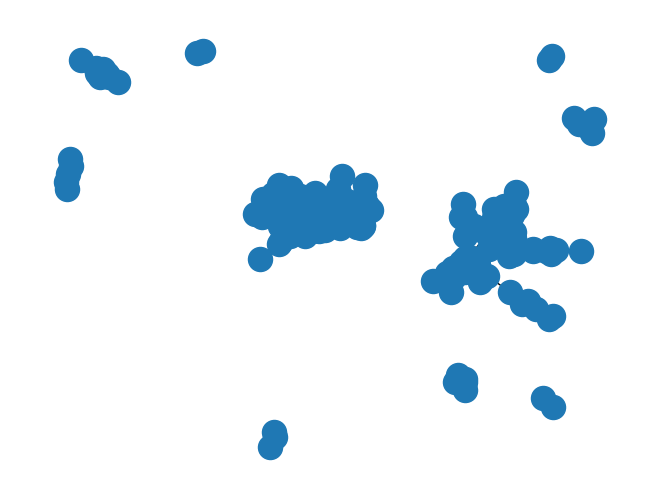

In [ ]:
communities = girvan_newman(G_0,10)
print('\n\ncommunities')
for c in communities:
  print('\n',c)

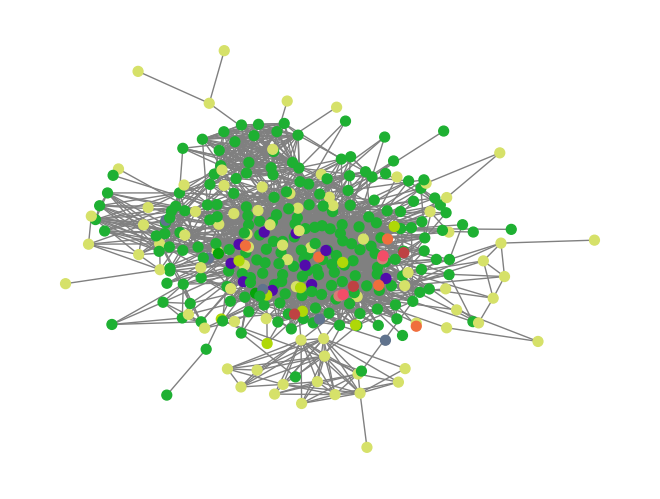

In [ ]:
girvan_newman_club(G_0,communities)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


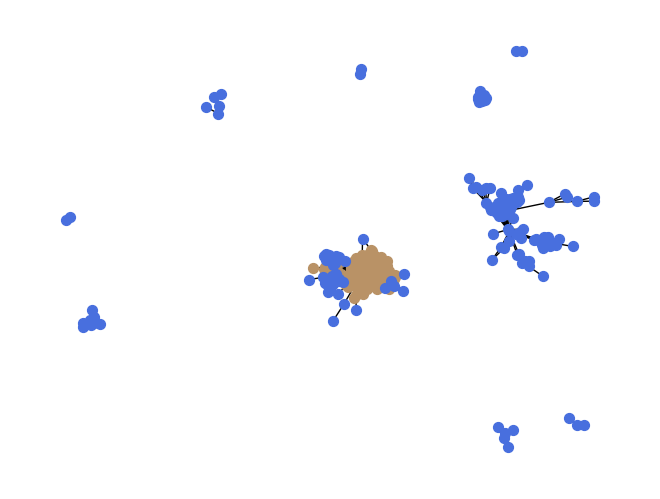

In [ ]:
radio_cut_method(G_0)

In [ ]:
adjusted_rand_score(get_community_labels(G_107, communities), get_circle_labels(G_107, circles_107))


0.0010857311623432766

Based on these results,the community detection identify social circles on Facebook poorly.



# **Node2Vec**

The `node2vec algorithm` is a popular algorithm that identifies vertex features (embeddings) for each vertex in an observed graph. These embeddings act as low-dimensional summaries of the vertices and can be used for machine learning tasks like clustering, classification, and prediction. Links to the source code, data, and publication are available [here](https://snap.stanford.edu/node2vec/)

*   Incorporated the node2vec algorithm (with default parameter settings) in the network analysis function. In particular, return D-dimensional embeddings for each vertex in the graph where D is chosen by the user as input. Verified that the new function works on the simple 20 node graph with `D = 10`.
*   Ran node2vec on the ego networks for vertex 0 and 107 from the Facebook data with `D = 30`. With the embeddings, following machine learning tasks applied for the subgraphs of vertex 0 and 107:
  -  Clustered the nodes using the node × embeddings matrix
  -  A simple prediction model is built where the input features are the node embeddings and the response is the social circle label of the node.


In [ ]:
def node2vec_from_graph(G, D):
    node2vec = Node2Vec(G, dimensions=D)
    model = node2vec.fit()
    embeddings = model.wv.vectors
    return embeddings

##K-Means clustering

In [ ]:
def kmeans(embeddings, n_clusters):
    ss = StandardScaler()
    X = ss.fit_transform(embeddings)
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    y_pred = km.predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("K-means")
    return km

In [ ]:
def prediction_model(G,embeddings,circles):

  X_train, X_test, y_train, y_test = train_test_split(embeddings, get_circle_labels(G, circles), test_size=0.33, random_state=42)

  rf = RandomForestClassifier()
  rf.fit(X_train,y_train)
  ypred = rf.predict(X_test)
  score = f1_score(y_test,ypred,average = "micro")
  return score


In [ ]:
embeddings = node2vec_from_graph(G_combined,10)
embeddings[0:3] # sample 3 example


Computing transition probabilities:   0%|          | 0/4041 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:06<00:00,  6.61s/it]


array([[-0.97280717,  0.32754278,  0.45795277, -0.11037759, -0.13179573,
         0.33459845,  1.9165101 ,  0.5692405 , -2.240984  ,  0.3328445 ],
       [ 1.4421084 , -0.442206  , -0.23410116,  0.3283692 , -0.7853734 ,
        -0.29817772,  0.9290717 ,  0.2664501 , -0.6013775 , -0.83522326],
       [ 0.19431399, -0.48874587, -0.7269977 , -0.5542127 ,  1.2421781 ,
        -0.95706946,  0.2746654 ,  1.0810955 , -1.2862316 , -1.0779569 ]],
      dtype=float32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 'warn',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

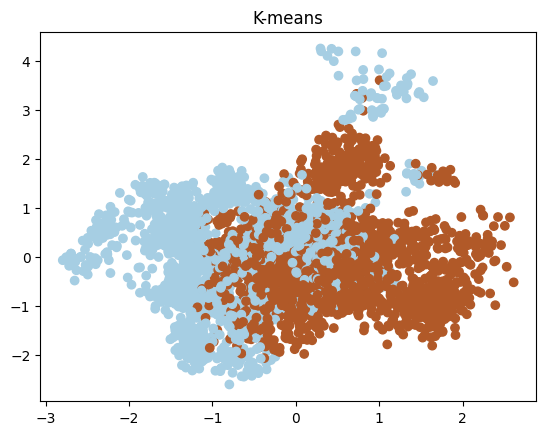

In [ ]:
kmean = kmeans(embeddings,n_clusters=2)
kmean.get_params()

In [ ]:
kmean.cluster_centers_

array([[-0.5391701 ,  0.13307922,  0.6600319 ,  0.09273598,  0.1464183 ,
         0.29848155, -0.12876128, -0.31089953, -0.7298814 ,  0.28323454],
       [ 0.490989  , -0.12118711, -0.6010501 , -0.08444891, -0.13333414,
        -0.27180877,  0.11725494,  0.28311673,  0.66465837, -0.25792414]],
      dtype=float32)

##For Node 0

In [ ]:
embeddings = node2vec_from_graph(G_0,30)
embeddings

Computing transition probabilities:   0%|          | 0/333 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


array([[ 0.48889065, -0.1709775 ,  0.45084637, ..., -0.36948642,
        -0.2290845 , -0.23214456],
       [ 0.3349493 , -0.26105806,  0.6161358 , ..., -0.16981065,
        -0.06350933, -0.05704589],
       [ 0.30694282, -0.32075086,  0.77901334, ..., -0.33328688,
        -0.24282904,  0.03880732],
       ...,
       [ 0.24811988,  0.1257468 ,  0.37756133, ..., -0.25871328,
        -0.22056249,  0.06943736],
       [ 0.4412469 , -0.8418247 ,  0.93326145, ...,  0.03412959,
        -0.36622062,  0.22230579],
       [ 0.6120625 , -0.39462712,  0.65387267, ..., -0.5175556 ,
        -0.24386832,  0.04783477]], dtype=float32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 'warn',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

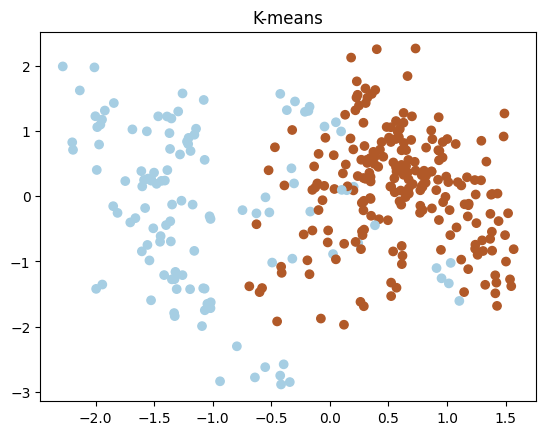

In [ ]:
kmean = kmeans(embeddings,n_clusters=2)
kmean.get_params()

In [ ]:
kmean.cluster_centers_

array([[-1.0598166 , -0.17310864, -0.16237363,  0.8497161 ,  0.644143  ,
        -0.64935714,  0.9762778 , -0.57565606, -1.0331271 ,  0.03181746,
         1.0495919 ,  0.13416597,  0.09262997, -0.16674419, -0.24910286,
        -0.7326139 , -0.63881385,  0.03771839, -0.17896764,  0.39565977,
         0.14192982, -0.6116309 ,  0.21457204,  0.66814923,  0.7942401 ,
         0.0613541 ,  0.37619713,  0.96031535,  0.8214264 , -0.76643723],
       [ 0.5970797 ,  0.09752607,  0.0914781 , -0.47871318, -0.3628974 ,
         0.365835  , -0.5500155 ,  0.32431325,  0.5820433 , -0.01792533,
        -0.5913195 , -0.07558652, -0.0521859 ,  0.09394035,  0.14033963,
         0.41274017,  0.35989514, -0.02124981,  0.1008269 , -0.22290681,
        -0.07996048,  0.3445807 , -0.12088563, -0.37642205, -0.4474592 ,
        -0.03456571, -0.21194209, -0.5410228 , -0.46277538,  0.4317956 ]],
      dtype=float32)

In [ ]:
print("F1 Score : ",prediction_model(G_0,embeddings,circles_0))


F1 Score :  0.37272727272727274


## For Node 107

In [ ]:
embeddings = node2vec_from_graph(G_107,30)
embeddings

Computing transition probabilities:   0%|          | 0/1034 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


array([[-0.41345072,  0.68469906, -0.08683977, ..., -0.00786056,
         0.2835885 , -0.40077633],
       [-0.03618991, -0.33228105,  0.38629958, ...,  0.20475976,
         0.2068518 , -0.844618  ],
       [-0.18895093, -0.33107632,  0.40122393, ..., -0.1436702 ,
         0.06010973, -0.60672194],
       ...,
       [ 0.11496111, -0.07669342, -0.19512054, ..., -0.46313488,
        -0.29039663, -0.79381764],
       [-0.3186102 , -0.23490205,  0.30177727, ..., -0.68244934,
         0.6515187 , -0.55995166],
       [-0.19696546, -0.04873019,  0.25917104, ..., -0.28614813,
         0.04261481, -0.72954214]], dtype=float32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 'warn',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

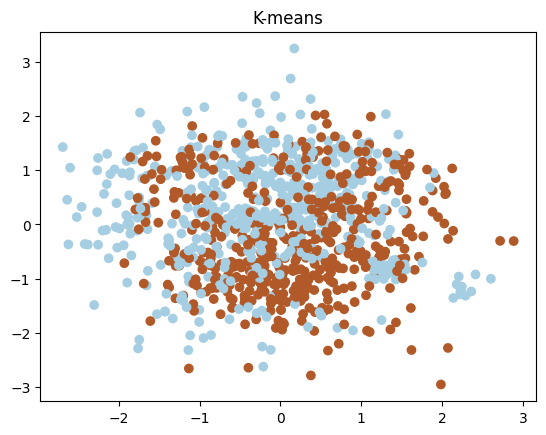

In [ ]:
kmean = kmeans(embeddings,n_clusters=2)
kmean.get_params()

In [ ]:
kmean.cluster_centers_

array([[-0.12054973,  0.23610361,  0.19097413,  0.34989774,  0.80032355,
         0.04588457,  0.6454866 , -0.38116217,  0.03437687, -0.6789042 ,
         0.5287167 ,  0.07331252,  0.23896739,  0.17648761,  0.09160726,
         0.52364445, -0.6532613 ,  0.32704532, -0.50639826,  0.33913237,
         0.46399358,  0.30479452,  0.16182189, -0.5514871 ,  0.40939665,
         0.14409997,  0.47068912, -0.2271736 ,  0.3296888 ,  0.24103649],
       [ 0.13025187, -0.2551058 , -0.20634426, -0.3780585 , -0.8647358 ,
        -0.04957755, -0.6974369 ,  0.4118391 , -0.03714363,  0.7335444 ,
        -0.57126945, -0.0792129 , -0.25820017, -0.19069193, -0.09898013,
        -0.5657889 ,  0.705838  , -0.3533668 ,  0.54715455, -0.36642683,
        -0.5013372 , -0.32932526, -0.17484571,  0.5958727 , -0.442346  ,
        -0.15569754, -0.5085715 ,  0.24545708, -0.35622314, -0.26043582]],
      dtype=float32)

In [ ]:
print("F1 Score : ",prediction_model(G_107,embeddings,circles_107))

F1 Score :  0.5175438596491229
